# [Предсказание кредитного рейтинга](https://www.kaggle.com/datasets/parisrohan/credit-score-classification/df?select=train.csv) (Credit score classification)

#### 1. Выбор набора данных и обоснование его выбора

Определение кредитного рейтинга остаётся важной задачей в банковской сфере. Крупные банки активно используют методы машинного обучения для решения различных экономических и финансовых задач

Для работы был выбран датасет с платформы Kaggle, содержащий множество признаков, связанных с кредитной историей и уровнем дохода человека. В датасете каждому человеку присвоен свой кредитный рейтинг.

#### 2. Выбор метрик качества и обоснование их выбора

В качестве метрик выбраны $accuracy$, $presicion$, $recall$ и $F1$-мера. Будем смотреть на них совместно, так как выбор только одной метрики (например, accuracy) не даёт полной картины об обучении, особенно если классы не сбалансированы и т.д.

#### 3. Бейзлайн

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from catboost import CatBoostClassifier
from scipy.stats import probplot
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, PowerTransformer, FunctionTransformer, OneHotEncoder, LabelEncoder
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, precision_score, recall_score, accuracy_score, f1_score
from imblearn.over_sampling import SMOTE
import category_encoders as ce
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import warnings #, re, joblib
warnings.filterwarnings("ignore")

In [7]:
df = pd.read_csv("train.csv")
df.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


Описание признаков:

1. ID: Идентификатор для каждой записи в наборе данных.
2. Customer_ID: Идентификатор для отдельных клиентов.
3. Month: Месяц, связанный с вводом данных.
4. Name: Имя клиента.
5. Age: Возраст клиента.
6. SSN: Номер социального страхования или какая-либо другая форма идентификации.
7. Occupation: род занятий или должность Клиента.
8. Annual_Income: годовой доход клиента.
9. Monthly_Inhand_Salary: Сумма денег, которую клиент ежемесячно получает в качестве заработной платы.
10. Num_Bank_Accounts: Количество банковских счетов, имеющихся у клиента.
11. Num_Credit_Card: Количество кредитных карт, которыми владеет клиент.
12. Interest_Rate: Процентная ставка, связанная с некоторым финансовым аспектом (например, займами или кредитными картами).
13. Num_of_Loan: Количество кредитов, имеющихся у клиента.
14. Type_of_Loan: Тип кредита (ов), который(ые) есть у клиента (например, ипотека, личный заем и т.д.).
15. Delay_from_due_date: Задержка платежей с установленной даты.
16. Num_of_Delayed_Payment: Количество просроченных платежей.
17. Changed_Credit_Limit: Указывает, изменил ли клиент свой кредитный лимит.
18. Num_Credit_Inquiries: Количество кредитных запросов, сделанных клиентом.
19. Credit_Mix: Сочетание различных типов кредитных счетов (например, кредитных карт, займов).
20. Outstanding_Debt: Сумма непогашенного долга.
21. Credit_Utilization_Ratio: Отношение использованного кредита к общему кредитному лимиту.
22. Credit_History_Age: Возраст кредитной истории клиента.
23. Payment_of_Min_Amount: Поведение платежа в отношении минимально необходимых платежей.
24. Total_EMI_per_month: Общая сумма платежей, произведенных клиентом равными ежемесячными платежами (EMI).
25. Amount_invested_monthly: Сумма, которую клиент инвестирует ежемесячно.
26. Payment_Behaviour: Поведение, связанное с платежами, возможно, указывающее на закономерности или тенденции.
27. Monthly_Balance: Ежемесячный баланс клиента на его финансовых счетах.
28. Credit_Score: Кредитный рейтинг, связанный с кредитоспособностью клиента.

In [8]:
df = pd.read_csv("train.csv", na_values =['_','_______','#F%$D@*&8','!@9#%8','nan'])

In [9]:
num_rows, num_cols = df.shape
print(df.shape)

(100000, 28)


In [10]:
df.duplicated().any()

False

In [11]:
data_types = df.dtypes
data_types

,0
ID,object
Customer_ID,object
Month,object
Name,object
Age,object
SSN,object
Occupation,object
Annual_Income,object
Monthly_Inhand_Salary,float64
Num_Bank_Accounts,int64


In [12]:
df.isnull().sum()

,0
ID,0
Customer_ID,0
Month,0
Name,9985
Age,0
SSN,5572
Occupation,7062
Annual_Income,0
Monthly_Inhand_Salary,15002
Num_Bank_Accounts,0


In [13]:
df.describe()

,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Delay_from_due_date,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Utilization_Ratio,Total_EMI_per_month
count,84998.000000,100000.000000,100000.00000,100000.000000,100000.000000,97909.000000,98035.000000,100000.000000,100000.000000
mean,4194.170850,17.091280,22.47443,72.466040,21.068780,10.389025,27.754251,32.285173,1403.118217
std,3183.686167,117.404834,129.05741,466.422621,14.860104,6.789496,193.177339,5.116875,8306.041270
min,303.645417,-1.000000,0.00000,1.000000,-5.000000,-6.490000,0.000000,20.000000,0.000000
25%,1625.568229,3.000000,4.00000,8.000000,10.000000,5.320000,3.000000,28.052567,30.306660
50%,3093.745000,6.000000,5.00000,13.000000,18.000000,9.400000,6.000000,32.305784,69.249473
75%,5957.448333,7.000000,7.00000,20.000000,28.000000,14.870000,9.000000,36.496663,161.224249
max,15204.633333,1798.000000,1499.00000,5797.000000,67.000000,36.970000,2597.000000,50.000000,82331.000000


In [14]:
df.describe(include='object')

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Num_of_Loan,Type_of_Loan,Num_of_Delayed_Payment,Credit_Mix,Outstanding_Debt,Credit_History_Age,Payment_of_Min_Amount,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
count,100000,100000,100000,90015,100000,94428,92938,100000,100000,88592,92998,79805,100000,90970,100000,95521,92400,98800,100000
unique,100000,12500,8,10139,1788,12500,15,18940,434,6260,749,3,13178,404,3,91049,6,98792,3
top,0x25fb6,CUS_0x942c,January,Langep,38,078-73-5990,Lawyer,20867.67,3,Not Specified,19,Standard,1360.45,15 Years and 11 Months,Yes,__10000__,Low_spent_Small_value_payments,__-333333333333333333333333333__,Standard
freq,1,8,12500,44,2833,8,6575,16,14386,1408,5327,36479,24,446,52326,4305,25513,9,53174


In [15]:
df['Month'] = pd.to_datetime(df['Month'],format="%B").dt.month
df['Month'] = df['Month'].astype(np.int64)

In [16]:
df.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,1,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,NaN,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,2,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,3,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,4,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,5,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


Очень много NaN значений, попробуем почистить данные и заполнить пропуски

In [17]:
features_to_be_num=['Age', 'Num_of_Loan']
for feature in features_to_be_num:
    df[feature] = df[feature].str.extract('(\d+)').astype(int)
df

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,1,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,NaN,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,2,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,3,Aaron Maashoh,500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,4,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,5,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0x25fe9,CUS_0x942c,4,Nicks,25,078-73-5990,Mechanic,39628.99,3359.415833,4,...,NaN,502.38,34.663572,31 Years and 6 Months,No,35.104023,60.97133255718485,High_spent_Large_value_payments,479.866228,Poor
99996,0x25fea,CUS_0x942c,5,Nicks,25,078-73-5990,Mechanic,39628.99,3359.415833,4,...,NaN,502.38,40.565631,31 Years and 7 Months,No,35.104023,54.18595028760385,High_spent_Medium_value_payments,496.65161,Poor
99997,0x25feb,CUS_0x942c,6,Nicks,25,078-73-5990,Mechanic,39628.99,3359.415833,4,...,Good,502.38,41.255522,31 Years and 8 Months,No,35.104023,24.02847744864441,High_spent_Large_value_payments,516.809083,Poor
99998,0x25fec,CUS_0x942c,7,Nicks,25,078-73-5990,Mechanic,39628.99,3359.415833,4,...,Good,502.38,33.638208,31 Years and 9 Months,No,35.104023,251.67258219721603,Low_spent_Large_value_payments,319.164979,Standard


In [18]:
features_to_be_num = ['Outstanding_Debt',
                      'Annual_Income',
                      'Amount_invested_monthly',
                      'Monthly_Balance']
for feature in features_to_be_num:
    df[feature] = df[feature].str.extract(r'(\d+\.\d+)').astype(float)
df

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,1,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,NaN,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.415295,High_spent_Small_value_payments,312.494089,Good
1,0x1603,CUS_0xd40,2,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.280222,Low_spent_Large_value_payments,284.629162,Good
2,0x1604,CUS_0xd40,3,Aaron Maashoh,500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521,Low_spent_Medium_value_payments,331.209863,Good
3,0x1605,CUS_0xd40,4,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.458074,Low_spent_Small_value_payments,223.451310,Good
4,0x1606,CUS_0xd40,5,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153,High_spent_Medium_value_payments,341.489231,Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0x25fe9,CUS_0x942c,4,Nicks,25,078-73-5990,Mechanic,39628.99,3359.415833,4,...,NaN,502.38,34.663572,31 Years and 6 Months,No,35.104023,60.971333,High_spent_Large_value_payments,NaN,Poor
99996,0x25fea,CUS_0x942c,5,Nicks,25,078-73-5990,Mechanic,39628.99,3359.415833,4,...,NaN,502.38,40.565631,31 Years and 7 Months,No,35.104023,54.185950,High_spent_Medium_value_payments,NaN,Poor
99997,0x25feb,CUS_0x942c,6,Nicks,25,078-73-5990,Mechanic,39628.99,3359.415833,4,...,Good,502.38,41.255522,31 Years and 8 Months,No,35.104023,24.028477,High_spent_Large_value_payments,NaN,Poor
99998,0x25fec,CUS_0x942c,7,Nicks,25,078-73-5990,Mechanic,39628.99,3359.415833,4,...,Good,502.38,33.638208,31 Years and 9 Months,No,35.104023,251.672582,Low_spent_Large_value_payments,NaN,Standard


In [19]:
df['Num_of_Delayed_Payment'] = df['Num_of_Delayed_Payment'].str.extract('(\d+)').astype(float)

In [20]:
df.describe()

,Month,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance
count,100000.000000,100000.000000,1.000000e+05,84998.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,92998.000000,97909.000000,98035.000000,100000.000000,100000.000000,100000.000000,91216.000000,97123.000000
mean,4.500000,119.509700,1.764157e+05,4194.170850,17.091280,22.47443,72.466040,10.761960,21.068780,30.946268,10.389025,27.754251,1426.220376,32.285173,1403.118217,195.539456,402.164483
std,2.291299,684.757313,1.429618e+06,3183.686167,117.404834,129.05741,466.422621,61.789933,14.860104,226.028754,6.789496,193.177339,1155.129026,5.116875,8306.041270,199.564527,213.644217
min,1.000000,14.000000,7.005930e+03,303.645417,-1.000000,0.00000,1.000000,0.000000,-5.000000,0.000000,-6.490000,0.000000,0.230000,20.000000,0.000000,0.000000,0.007760
25%,2.750000,25.000000,1.945750e+04,1625.568229,3.000000,4.00000,8.000000,2.000000,10.000000,9.000000,5.320000,3.000000,566.072500,28.052567,30.306660,72.236692,269.998334
50%,4.500000,34.000000,3.757861e+04,3093.745000,6.000000,5.00000,13.000000,3.000000,18.000000,14.000000,9.400000,6.000000,1166.155000,32.305784,69.249473,128.954538,336.472111
75%,6.250000,42.000000,7.279092e+04,5957.448333,7.000000,7.00000,20.000000,6.000000,28.000000,18.000000,14.870000,9.000000,1945.962500,36.496663,161.224249,236.815814,469.652004
max,8.000000,8698.000000,2.419806e+07,15204.633333,1798.000000,1499.00000,5797.000000,1496.000000,67.000000,4397.000000,36.970000,2597.000000,4998.070000,50.000000,82331.000000,1977.326102,1602.040519


Заполняем пропуски

In [21]:
df['Name'].value_counts()

,count
Name,
Langep,44
Stevex,44
Jessicad,39
Vaughanl,39
Danielz,38
...,...
Vellacotto,4
Josephine Masonz,4
ra Alperz,4


In [22]:
df[df['Name'].isnull()]

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
7,0x1609,CUS_0xd40,8,NaN,23,NaN,Scientist,19114.12,1824.843333,3,...,Good,809.98,23.933795,NaN,No,49.574949,24.785217,High_spent_Medium_value_payments,358.124168,Standard
17,0x161b,CUS_0x2dbc,2,NaN,34,486-85-3974,Engineer,143162.64,12187.220000,1,...,Good,1303.01,41.702573,17 Years and 10 Months,No,246.992319,232.860384,High_spent_Small_value_payments,998.869297,Good
22,0x1620,CUS_0x2dbc,7,NaN,34,486-85-3974,Engineer,143162.64,12187.220000,1,...,Good,1303.01,38.068624,18 Years and 3 Months,No,246.992319,263.174163,High_spent_Small_value_payments,968.555517,Standard
64,0x1662,CUS_0x4157,1,NaN,23,070-19-1622,Doctor,114838.41,9843.867500,2,...,Good,1377.74,33.664554,21 Years and 4 Months,No,226.892792,215.193516,High_spent_Small_value_payments,802.300442,Good
80,0x167a,CUS_0xa66b,1,NaN,40,221-30-8554,Teacher,33751.27,2948.605833,5,...,Standard,1328.93,37.089076,19 Years and 2 Months,NM,65.008174,117.306697,High_spent_Medium_value_payments,362.545712,Standard
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99964,0x25fba,CUS_0x372c,5,NaN,18,340-85-7301,Lawyer,42903.79,3468.315833,0,...,Good,1079.48,23.140640,28 Years and 5 Months,No,34.975457,450.646093,Low_spent_Small_value_payments,NaN,Good
99965,0x25fbb,CUS_0x372c,6,NaN,19,340-85-7301,Lawyer,42903.79,3468.315833,0,...,Good,1079.48,35.549456,28 Years and 6 Months,No,34.975457,187.355969,Low_spent_Large_value_payments,NaN,Good
99969,0x25fc3,CUS_0xf16,2,NaN,45,868-70-2218,Media_Manager,16680.35,1528.029167,1,...,Good,897.16,34.085971,21 Years and 2 Months,No,41.113561,104.646237,High_spent_Small_value_payments,NaN,Good
99973,0x25fc7,CUS_0xf16,6,NaN,45,868-70-2218,Media_Manager,16680.35,1528.029167,1,...,Good,897.16,24.972853,21 Years and 6 Months,No,41.113561,NaN,Low_spent_Small_value_payments,NaN,Good


In [23]:
df[df['Customer_ID']=='CUS_0xd40']

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,1,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,NaN,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.415295,High_spent_Small_value_payments,312.494089,Good
1,0x1603,CUS_0xd40,2,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.280222,Low_spent_Large_value_payments,284.629162,Good
2,0x1604,CUS_0xd40,3,Aaron Maashoh,500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521,Low_spent_Medium_value_payments,331.209863,Good
3,0x1605,CUS_0xd40,4,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.458074,Low_spent_Small_value_payments,223.451310,Good
4,0x1606,CUS_0xd40,5,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153,High_spent_Medium_value_payments,341.489231,Good
5,0x1607,CUS_0xd40,6,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,27.262259,22 Years and 6 Months,No,49.574949,62.430172,NaN,340.479212,Good
6,0x1608,CUS_0xd40,7,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,22.537593,22 Years and 7 Months,No,49.574949,178.344067,Low_spent_Small_value_payments,244.565317,Good
7,0x1609,CUS_0xd40,8,NaN,23,NaN,Scientist,19114.12,1824.843333,3,...,Good,809.98,23.933795,NaN,No,49.574949,24.785217,High_spent_Medium_value_payments,358.124168,Standard


Единственная колонка, в которой поменялось изменение кредитного рейтинга с хорошего на стандартный, - это поведение при оплате.

In [24]:
df[(df['Name'].isnull()) & (df['SSN'].isnull())]

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
7,0x1609,CUS_0xd40,8,NaN,23,NaN,Scientist,19114.120,1824.843333,3,...,Good,809.98,23.933795,NaN,No,49.574949,24.785217,High_spent_Medium_value_payments,358.124168,Standard
160,0x16f2,CUS_0x132f,1,NaN,41,NaN,Musician,19514.880,1828.240000,7,...,NaN,881.40,26.084543,19 Years and 3 Months,NM,0.000000,50.143727,High_spent_Medium_value_payments,382.680273,Standard
345,0x1807,CUS_0xc65,2,NaN,21,NaN,NaN,148699.320,12432.610000,3,...,Good,949.38,28.510775,30 Years and 8 Months,No,364.915177,237.918381,High_spent_Large_value_payments,880.427442,Good
400,0x185a,CUS_0xb14,1,NaN,25,NaN,Manager,49967.010,4091.917500,7,...,Standard,2253.95,28.875738,16 Years and 10 Months,Yes,156.003312,66.931995,High_spent_Large_value_payments,426.256443,Poor
449,0x18a3,CUS_0x3f5b,2,NaN,25,NaN,Doctor,80108.310,6866.692500,5,...,Standard,997.28,26.173145,17 Years and 8 Months,Yes,0.000000,52.189810,High_spent_Large_value_payments,874.479440,Standard
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98513,0x2573b,CUS_0x9d04,2,NaN,47,NaN,Developer,93841.650,8115.137500,0,...,Good,1042.20,37.181002,15 Years and 2 Months,NM,52.686572,90.015173,High_spent_Medium_value_payments,NaN,Poor
98668,0x25822,CUS_0x797a,5,NaN,18,NaN,Media_Manager,160016.440,13477.703333,2,...,Good,1123.32,42.276238,22 Years and 7 Months,No,86.881540,89.760441,High_spent_Large_value_payments,NaN,Good
98771,0x258bd,CUS_0x29f5,4,NaN,36,NaN,Developer,101316.640,8526.053333,3,...,Standard,559.18,39.097086,18 Years and 4 Months,No,166.272881,534.778826,High_spent_Small_value_payments,NaN,Standard
99534,0x25d34,CUS_0x85dd,7,NaN,45,NaN,Lawyer,8974.555,783.879583,10,...,Bad,1660.14,32.508883,16 Years and 9 Months,Yes,30.443262,88.395591,Low_spent_Small_value_payments,NaN,Standard


Можем заполнить Name и SNN, используя Customer_ID

In [25]:
Customer_IDs = df[df['Name'].isnull()]['Customer_ID'].values

In [26]:
for id in Customer_IDs:
    realName = ''
    realName = df.loc[(df['Customer_ID'] == id) & (df['Name'].notna())]['Name'].values[0]
    df.loc[(df['Customer_ID'] == id) & (df['Name'].isna()), ['Name']] = realName

In [27]:
df[df['Customer_ID']=='CUS_0xd40']

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,1,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,NaN,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.415295,High_spent_Small_value_payments,312.494089,Good
1,0x1603,CUS_0xd40,2,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.280222,Low_spent_Large_value_payments,284.629162,Good
2,0x1604,CUS_0xd40,3,Aaron Maashoh,500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521,Low_spent_Medium_value_payments,331.209863,Good
3,0x1605,CUS_0xd40,4,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.458074,Low_spent_Small_value_payments,223.451310,Good
4,0x1606,CUS_0xd40,5,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153,High_spent_Medium_value_payments,341.489231,Good
5,0x1607,CUS_0xd40,6,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,27.262259,22 Years and 6 Months,No,49.574949,62.430172,NaN,340.479212,Good
6,0x1608,CUS_0xd40,7,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,22.537593,22 Years and 7 Months,No,49.574949,178.344067,Low_spent_Small_value_payments,244.565317,Good
7,0x1609,CUS_0xd40,8,Aaron Maashoh,23,NaN,Scientist,19114.12,1824.843333,3,...,Good,809.98,23.933795,NaN,No,49.574949,24.785217,High_spent_Medium_value_payments,358.124168,Standard


In [28]:
df['Name'].isnull()

,Name
0,False
1,False
2,False
3,False
4,False
...,...
99995,False
99996,False
99997,False
99998,False


In [29]:
df[(df['Name'].isnull()) | (df['SSN'].isnull())]

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
7,0x1609,CUS_0xd40,8,Aaron Maashoh,23,NaN,Scientist,19114.12,1824.843333,3,...,Good,809.98,23.933795,NaN,No,49.574949,24.785217,High_spent_Medium_value_payments,358.124168,Standard
29,0x162b,CUS_0xb891,6,Jasond,55,NaN,NaN,30689.89,2612.490833,2,...,NaN,632.46,27.445422,17 Years and 8 Months,No,16.415452,84.952848,High_spent_Small_value_payments,419.880784,Standard
51,0x164d,CUS_0x284a,4,Nadiaq,34,NaN,Lawyer,131313.40,10469.207759,0,...,Good,352.16,42.645785,30 Years and 10 Months,No,23834.000000,337.434956,High_spent_Medium_value_payments,899.198772,Good
54,0x1650,CUS_0x284a,7,Nadiaq,34,NaN,Lawyer,10909427.00,NaN,0,...,Good,352.16,26.947565,31 Years and 1 Months,No,911.220179,930.391898,NaN,326.241830,Good
98,0x1694,CUS_0x3e45,3,Harriet McLeodd,35,NaN,Entrepreneur,54392.16,NaN,6,...,NaN,179.22,31.258928,27 Years and 0 Months,NM,124.392082,33.349569,High_spent_Large_value_payments,558.926349,Standard
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99914,0x25f70,CUS_0x1619,3,Phil Wahbao,54,NaN,Media_Manager,20059.98,1523.665000,8,...,Good,909.01,29.204711,16 Years and 5 Months,No,45.076827,111.567139,Low_spent_Large_value_payments,NaN,Poor
99942,0x25f98,CUS_0xad4f,7,Sabina Zawadzkig,48,NaN,Developer,22620.79,1722.065833,6,...,Standard,642.46,24.714779,29 Years and 9 Months,No,0.000000,16.532189,High_spent_Large_value_payments,NaN,Poor
99946,0x25fa0,CUS_0x51b3,3,Ryana,33,NaN,Media_Manager,59146.36,4908.863333,2,...,Good,418.03,35.750925,20 Years and 3 Months,No,26.778419,188.544697,High_spent_Medium_value_payments,NaN,Standard
99968,0x25fc2,CUS_0xf16,1,Maria Sheahanb,44,NaN,Media_Manager,16680.35,1528.029167,1,...,Good,897.16,39.868572,NaN,NM,41.113561,52.951978,High_spent_Small_value_payments,NaN,Good


In [30]:
Customer_IDs = df[df['SSN']== 'NaN']['Customer_ID'].values
Customer_IDs

array([], dtype=object)

In [31]:
ssn_mapping = df.dropna(subset=['SSN']).set_index('Customer_ID')['SSN'].to_dict()
df['SSN'] = df.apply(lambda row: ssn_mapping.get(row['Customer_ID'], row['SSN']), axis=1)

In [32]:
df[(df['Name'].isnull()) | (df['SSN'].isnull())]

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score


In [33]:
df[df['Customer_ID']=='CUS_0xb891']

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
24,0x1626,CUS_0xb891,1,Jasond,54,072-31-6145,Entrepreneur,30689.89,2612.490833,2,...,Good,632.46,26.544229,17 Years and 3 Months,No,16.415452,81.228859,Low_spent_Large_value_payments,433.604773,Standard
25,0x1627,CUS_0xb891,2,Jasond,54,072-31-6145,Entrepreneur,30689.89,2612.490833,2,...,Good,632.46,35.279982,17 Years and 4 Months,No,16.415452,124.881820,Low_spent_Small_value_payments,409.951812,Standard
26,0x1628,CUS_0xb891,3,Jasond,55,072-31-6145,Entrepreneur,30689.89,2612.490833,2,...,Good,632.46,32.301163,17 Years and 5 Months,NM,16.415452,83.406509,High_spent_Medium_value_payments,411.427123,Standard
27,0x1629,CUS_0xb891,4,Jasond,55,072-31-6145,Entrepreneur,30689.89,2612.490833,2,...,Good,632.46,38.132348,17 Years and 6 Months,No,16.415452,272.334037,Low_spent_Small_value_payments,262.499594,Standard
28,0x162a,CUS_0xb891,5,Jasond,55,072-31-6145,Entrepreneur,30689.89,2612.490833,2,...,Good,632.46,41.154317,17 Years and 7 Months,No,16.415452,NaN,Low_spent_Large_value_payments,359.374916,Standard
29,0x162b,CUS_0xb891,6,Jasond,55,072-31-6145,NaN,30689.89,2612.490833,2,...,NaN,632.46,27.445422,17 Years and 8 Months,No,16.415452,84.952848,High_spent_Small_value_payments,419.880784,Standard
30,0x162c,CUS_0xb891,7,Jasond,55,072-31-6145,Entrepreneur,30689.89,2612.490833,2,...,Good,632.46,26.056395,17 Years and 9 Months,No,16.415452,71.283675,Low_spent_Large_value_payments,443.549957,Standard
31,0x162d,CUS_0xb891,8,Jasond,55,072-31-6145,Entrepreneur,30689.89,2612.490833,2,...,Good,632.46,27.332515,17 Years and 10 Months,No,16.415452,125.617251,High_spent_Small_value_payments,379.216381,Standard


In [34]:
df[df['Customer_ID']=='CUS_0xd40']

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,1,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,NaN,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.415295,High_spent_Small_value_payments,312.494089,Good
1,0x1603,CUS_0xd40,2,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.280222,Low_spent_Large_value_payments,284.629162,Good
2,0x1604,CUS_0xd40,3,Aaron Maashoh,500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521,Low_spent_Medium_value_payments,331.209863,Good
3,0x1605,CUS_0xd40,4,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.458074,Low_spent_Small_value_payments,223.451310,Good
4,0x1606,CUS_0xd40,5,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153,High_spent_Medium_value_payments,341.489231,Good
5,0x1607,CUS_0xd40,6,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,27.262259,22 Years and 6 Months,No,49.574949,62.430172,NaN,340.479212,Good
6,0x1608,CUS_0xd40,7,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,22.537593,22 Years and 7 Months,No,49.574949,178.344067,Low_spent_Small_value_payments,244.565317,Good
7,0x1609,CUS_0xd40,8,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,23.933795,NaN,No,49.574949,24.785217,High_spent_Medium_value_payments,358.124168,Standard


In [35]:
df.SSN = df.SSN.apply(lambda x: int(''.join(x.split('-'))) if pd.notna(x) else x).astype(np.int64)

In [36]:
df[df['Occupation'].isnull()]

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
8,0x160e,CUS_0x21b1,1,Rick Rothackerj,28,4075839,NaN,34847.84,3037.986667,2,...,Good,605.03,24.464031,26 Years and 7 Months,No,18.816215,104.291825,Low_spent_Small_value_payments,470.690627,Standard
16,0x161a,CUS_0x2dbc,1,Langep,34,486853974,NaN,143162.64,12187.220000,1,...,Good,1303.01,28.616735,17 Years and 9 Months,No,246.992319,168.413703,NaN,1043.315978,Good
18,0x161c,CUS_0x2dbc,3,Langep,34,486853974,NaN,143162.64,NaN,1,...,Good,1303.01,26.519815,17 Years and 11 Months,No,246.992319,NaN,High_spent_Small_value_payments,715.741367,Good
20,0x161e,CUS_0x2dbc,5,Langep,34,486853974,NaN,143162.64,12187.220000,1,...,Good,1303.01,31.376150,18 Years and 1 Months,No,246.992319,430.947528,Low_spent_Large_value_payments,810.782153,Good
29,0x162b,CUS_0xb891,6,Jasond,55,72316145,NaN,30689.89,2612.490833,2,...,NaN,632.46,27.445422,17 Years and 8 Months,No,16.415452,84.952848,High_spent_Small_value_payments,419.880784,Standard
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99920,0x25f7a,CUS_0x2654,1,enj,37,647678889,NaN,139664.96,11777.746667,3,...,NaN,365.66,31.043048,29 Years and 7 Months,Yes,423.731016,282.782346,High_spent_Large_value_payments,NaN,Standard
99935,0x25f8d,CUS_0xb11c,8,Yinka Adegokej,38,546944789,NaN,15319.65,1460.637500,6,...,Bad,1453.61,34.557510,11 Years and 4 Months,Yes,28.182033,191.877779,Low_spent_Small_value_payments,NaN,Poor
99937,0x25f93,CUS_0xad4f,2,Sabina Zawadzkig,500,226450652,NaN,22620.79,1722.065833,7,...,Standard,642.46,31.841872,NaN,No,0.000000,105.076293,Low_spent_Large_value_payments,NaN,Standard
99943,0x25f99,CUS_0xad4f,8,Sabina Zawadzkig,48,226450652,NaN,22620.79,NaN,6,...,NaN,642.46,34.026427,29 Years and 10 Months,No,0.000000,205.217280,Low_spent_Small_value_payments,NaN,Poor


In [37]:
Occupation_mapping = df.dropna(subset=['Occupation']).set_index('Customer_ID')['Occupation'].to_dict()

df['Occupation'] = df.apply(lambda row: Occupation_mapping.get(row['Customer_ID'], row['Occupation']), axis=1)

In [38]:
df['Type_of_Loan'].unique()

array(['Auto Loan, Credit-Builder Loan, Personal Loan, and Home Equity Loan',
       'Credit-Builder Loan', 'Auto Loan, Auto Loan, and Not Specified',
       ..., 'Home Equity Loan, Auto Loan, Auto Loan, and Auto Loan',
       'Payday Loan, Student Loan, Mortgage Loan, and Not Specified',
       'Personal Loan, Auto Loan, Mortgage Loan, Student Loan, and Student Loan'],
      dtype=object)

In [39]:
df[df['Type_of_Loan'].isnull()]

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
32,0x1632,CUS_0x1cdb,1,Deepaa,21,615067821,Developer,35547.71,2853.309167,7,...,Standard,943.86,39.797764,30 Years and 8 Months,Yes,0.0,276.725394,NaN,288.605522,Standard
33,0x1633,CUS_0x1cdb,2,Deepaa,21,615067821,Developer,35547.71,NaN,7,...,Standard,943.86,27.020360,30 Years and 9 Months,NM,0.0,74.443641,High_spent_Medium_value_payments,460.887276,Standard
34,0x1634,CUS_0x1cdb,3,Deepaa,21,615067821,Developer,35547.71,2853.309167,7,...,Standard,943.86,23.462303,30 Years and 10 Months,Yes,0.0,173.138651,Low_spent_Medium_value_payments,392.192266,Standard
35,0x1635,CUS_0x1cdb,4,Deepaa,21,615067821,Developer,35547.71,2853.309167,7,...,NaN,943.86,28.924954,30 Years and 11 Months,Yes,0.0,96.785485,High_spent_Medium_value_payments,438.545432,Standard
36,0x1636,CUS_0x1cdb,5,Deepaa,21,615067821,Developer,35547.71,2853.309167,7,...,NaN,943.86,41.776187,31 Years and 0 Months,Yes,0.0,62.723278,High_spent_Small_value_payments,482.607638,Standard
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99939,0x25f95,CUS_0xad4f,4,Sabina Zawadzkig,47,226450652,Developer,22620.79,1722.065833,7,...,NaN,642.46,26.730863,29 Years and 6 Months,NM,0.0,205.756074,Low_spent_Small_value_payments,NaN,Poor
99940,0x25f96,CUS_0xad4f,5,Sabina Zawadzkig,47,226450652,Developer,22620.79,1722.065833,7,...,Standard,642.46,37.450793,29 Years and 7 Months,No,0.0,141.895743,Low_spent_Large_value_payments,NaN,Standard
99941,0x25f97,CUS_0xad4f,6,Sabina Zawadzkig,47,226450652,Developer,22620.79,1722.065833,7,...,Standard,642.46,27.699504,NaN,No,0.0,207.473456,Low_spent_Small_value_payments,NaN,Poor
99942,0x25f98,CUS_0xad4f,7,Sabina Zawadzkig,48,226450652,Developer,22620.79,1722.065833,6,...,Standard,642.46,24.714779,29 Years and 9 Months,No,0.0,16.532189,High_spent_Large_value_payments,NaN,Poor


In [40]:
df[df['Name']=='Sabina Zawadzkig']

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
99936,0x25f92,CUS_0xad4f,1,Sabina Zawadzkig,47,226450652,Developer,22620.79,1722.065833,7,...,Standard,642.46,31.605703,29 Years and 3 Months,No,0.0,56.072675,High_spent_Medium_value_payments,NaN,Standard
99937,0x25f93,CUS_0xad4f,2,Sabina Zawadzkig,500,226450652,Developer,22620.79,1722.065833,7,...,Standard,642.46,31.841872,NaN,No,0.0,105.076293,Low_spent_Large_value_payments,NaN,Standard
99938,0x25f94,CUS_0xad4f,3,Sabina Zawadzkig,47,226450652,Developer,22620.79,1722.065833,7,...,NaN,642.46,26.622486,29 Years and 5 Months,No,0.0,29.108505,High_spent_Large_value_payments,NaN,Standard
99939,0x25f95,CUS_0xad4f,4,Sabina Zawadzkig,47,226450652,Developer,22620.79,1722.065833,7,...,NaN,642.46,26.730863,29 Years and 6 Months,NM,0.0,205.756074,Low_spent_Small_value_payments,NaN,Poor
99940,0x25f96,CUS_0xad4f,5,Sabina Zawadzkig,47,226450652,Developer,22620.79,1722.065833,7,...,Standard,642.46,37.450793,29 Years and 7 Months,No,0.0,141.895743,Low_spent_Large_value_payments,NaN,Standard
99941,0x25f97,CUS_0xad4f,6,Sabina Zawadzkig,47,226450652,Developer,22620.79,1722.065833,7,...,Standard,642.46,27.699504,NaN,No,0.0,207.473456,Low_spent_Small_value_payments,NaN,Poor
99942,0x25f98,CUS_0xad4f,7,Sabina Zawadzkig,48,226450652,Developer,22620.79,1722.065833,6,...,Standard,642.46,24.714779,29 Years and 9 Months,No,0.0,16.532189,High_spent_Large_value_payments,NaN,Poor
99943,0x25f99,CUS_0xad4f,8,Sabina Zawadzkig,48,226450652,Developer,22620.79,NaN,6,...,NaN,642.46,34.026427,29 Years and 10 Months,No,0.0,205.217280,Low_spent_Small_value_payments,NaN,Poor


In [41]:
df[df['Occupation']=='Developer']

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
32,0x1632,CUS_0x1cdb,1,Deepaa,21,615067821,Developer,35547.71,2853.309167,7,...,Standard,943.86,39.797764,30 Years and 8 Months,Yes,0.0,276.725394,NaN,288.605522,Standard
33,0x1633,CUS_0x1cdb,2,Deepaa,21,615067821,Developer,35547.71,NaN,7,...,Standard,943.86,27.020360,30 Years and 9 Months,NM,0.0,74.443641,High_spent_Medium_value_payments,460.887276,Standard
34,0x1634,CUS_0x1cdb,3,Deepaa,21,615067821,Developer,35547.71,2853.309167,7,...,Standard,943.86,23.462303,30 Years and 10 Months,Yes,0.0,173.138651,Low_spent_Medium_value_payments,392.192266,Standard
35,0x1635,CUS_0x1cdb,4,Deepaa,21,615067821,Developer,35547.71,2853.309167,7,...,NaN,943.86,28.924954,30 Years and 11 Months,Yes,0.0,96.785485,High_spent_Medium_value_payments,438.545432,Standard
36,0x1636,CUS_0x1cdb,5,Deepaa,21,615067821,Developer,35547.71,2853.309167,7,...,NaN,943.86,41.776187,31 Years and 0 Months,Yes,0.0,62.723278,High_spent_Small_value_payments,482.607638,Standard
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99939,0x25f95,CUS_0xad4f,4,Sabina Zawadzkig,47,226450652,Developer,22620.79,1722.065833,7,...,NaN,642.46,26.730863,29 Years and 6 Months,NM,0.0,205.756074,Low_spent_Small_value_payments,NaN,Poor
99940,0x25f96,CUS_0xad4f,5,Sabina Zawadzkig,47,226450652,Developer,22620.79,1722.065833,7,...,Standard,642.46,37.450793,29 Years and 7 Months,No,0.0,141.895743,Low_spent_Large_value_payments,NaN,Standard
99941,0x25f97,CUS_0xad4f,6,Sabina Zawadzkig,47,226450652,Developer,22620.79,1722.065833,7,...,Standard,642.46,27.699504,NaN,No,0.0,207.473456,Low_spent_Small_value_payments,NaN,Poor
99942,0x25f98,CUS_0xad4f,7,Sabina Zawadzkig,48,226450652,Developer,22620.79,1722.065833,6,...,Standard,642.46,24.714779,29 Years and 9 Months,No,0.0,16.532189,High_spent_Large_value_payments,NaN,Poor


Похоже, что многие виды займов для разработчиков являются NaN'ами

In [42]:
df[(df['Occupation'] != 'Developer') & (df['Type_of_Loan'].isnull())]

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
40,0x163e,CUS_0x95ee,1,Np,31,612708987,Lawyer,73928.46,NaN,4,...,Good,548.20,39.962685,NaN,No,15015.0,98.674410,High_spent_Large_value_payments,740.196090,Good
41,0x163f,CUS_0x95ee,2,Np,31,612708987,Lawyer,73928.46,5988.705,4,...,Good,548.20,42.769864,32 Years and 0 Months,NM,0.0,172.939214,Low_spent_Medium_value_payments,705.931286,Good
42,0x1640,CUS_0x95ee,3,Np,31,612708987,Lawyer,73928.46,5988.705,4,...,Good,548.20,40.712187,NaN,No,0.0,150.059734,High_spent_Medium_value_payments,698.810766,Good
43,0x1641,CUS_0x95ee,4,Np,31,612708987,Lawyer,73928.46,5988.705,4,...,Good,548.20,30.201658,32 Years and 2 Months,No,0.0,618.202391,Low_spent_Small_value_payments,270.668109,Good
44,0x1642,CUS_0x95ee,5,Np,31,612708987,Lawyer,73928.46,5988.705,4,...,NaN,548.20,26.333310,32 Years and 3 Months,No,0.0,177.951836,Low_spent_Large_value_payments,690.918664,Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99907,0x25f65,CUS_0xa053,4,t Astridn,39,94815856,Writer,87695.34,7337.945,2,...,Good,361.68,26.745973,19 Years and 4 Months,No,0.0,154.229428,NaN,NaN,Standard
99908,0x25f66,CUS_0xa053,5,t Astridn,4808,94815856,Writer,87695.34,7337.945,2,...,Good,361.68,28.147193,19 Years and 5 Months,No,65671.0,168.798784,High_spent_Large_value_payments,NaN,Standard
99909,0x25f67,CUS_0xa053,6,t Astridn,39,94815856,Writer,87695.34,7337.945,2,...,Good,361.68,34.561012,19 Years and 6 Months,No,0.0,119.328999,High_spent_Medium_value_payments,NaN,Standard
99910,0x25f68,CUS_0xa053,7,t Astridn,39,94815856,Writer,87695.34,NaN,2,...,Good,361.68,42.042234,NaN,No,0.0,160.701966,High_spent_Small_value_payments,NaN,Standard


In [43]:
df[df['Name']=='Np']

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
40,0x163e,CUS_0x95ee,1,Np,31,612708987,Lawyer,73928.46,NaN,4,...,Good,548.2,39.962685,NaN,No,15015.0,98.674410,High_spent_Large_value_payments,740.196090,Good
41,0x163f,CUS_0x95ee,2,Np,31,612708987,Lawyer,73928.46,5988.705,4,...,Good,548.2,42.769864,32 Years and 0 Months,NM,0.0,172.939214,Low_spent_Medium_value_payments,705.931286,Good
42,0x1640,CUS_0x95ee,3,Np,31,612708987,Lawyer,73928.46,5988.705,4,...,Good,548.2,40.712187,NaN,No,0.0,150.059734,High_spent_Medium_value_payments,698.810766,Good
43,0x1641,CUS_0x95ee,4,Np,31,612708987,Lawyer,73928.46,5988.705,4,...,Good,548.2,30.201658,32 Years and 2 Months,No,0.0,618.202391,Low_spent_Small_value_payments,270.668109,Good
44,0x1642,CUS_0x95ee,5,Np,31,612708987,Lawyer,73928.46,5988.705,4,...,NaN,548.2,26.333310,32 Years and 3 Months,No,0.0,177.951836,Low_spent_Large_value_payments,690.918664,Good
45,0x1643,CUS_0x95ee,6,Np,31,612708987,Lawyer,73928.46,5988.705,4,...,Good,548.2,35.275437,NaN,No,15515.0,235.790325,Low_spent_Large_value_payments,633.080175,Good
46,0x1644,CUS_0x95ee,7,Np,31,612708987,Lawyer,73928.46,5988.705,4,...,NaN,548.2,36.624791,32 Years and 5 Months,No,0.0,348.509400,High_spent_Small_value_payments,510.361100,Standard
47,0x1645,CUS_0x95ee,8,Np,31,612708987,Lawyer,73928.46,5988.705,4,...,Good,548.2,31.580990,32 Years and 6 Months,No,0.0,42.635590,NaN,796.234910,Good


In [44]:
df[(df['Occupation'] == 'Writer')][['ID', 'Customer_ID', 'Month', 'Name', 'Age', 'SSN', 'Occupation',
       'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Type_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Credit_History_Age']]

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age
208,0x173a,CUS_0xb95f,1,Ashleyk,30,467131148,Writer,34290.12,2697.510000,9,...,7,"Home Equity Loan, Credit-Builder Loan, Credit-...",52,10.0,17.96,9.0,Standard,2686.81,39.280296,13 Years and 8 Months
209,0x173b,CUS_0xb95f,2,Ashleyk,30,467131148,Writer,34290.12,2697.510000,9,...,7,"Home Equity Loan, Credit-Builder Loan, Credit-...",47,NaN,13.96,9.0,Standard,2686.81,27.036842,NaN
210,0x173c,CUS_0xb95f,3,Ashleyk,30,467131148,Writer,34290.12,2697.510000,9,...,7,"Home Equity Loan, Credit-Builder Loan, Credit-...",52,6.0,12.96,9.0,NaN,2686.81,29.018850,NaN
211,0x173d,CUS_0xb95f,4,Ashleyk,30,467131148,Writer,34290.12,NaN,9,...,100,"Home Equity Loan, Credit-Builder Loan, Credit-...",52,7.0,13.96,9.0,Standard,2686.81,36.163989,13 Years and 11 Months
212,0x173e,CUS_0xb95f,5,Ashleyk,30,467131148,Writer,34290.12,2697.510000,9,...,7,"Home Equity Loan, Credit-Builder Loan, Credit-...",52,12.0,13.96,9.0,NaN,2686.81,33.841866,14 Years and 0 Months
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99979,0x25fd1,CUS_0xaf61,4,Chris Wickhamm,49,133167738,Writer,37188.10,3097.008333,1,...,3,"Home Equity Loan, Mortgage Loan, and Student Loan",3,12.0,5.38,3.0,Good,620.64,36.979007,30 Years and 0 Months
99980,0x25fd2,CUS_0xaf61,5,Chris Wickhamm,49,133167738,Writer,37188.10,3097.008333,1,...,3,"Home Equity Loan, Mortgage Loan, and Student Loan",7,12.0,5.38,3.0,NaN,620.64,27.495263,30 Years and 1 Months
99981,0x25fd3,CUS_0xaf61,6,Chris Wickhamm,50,133167738,Writer,37188.10,3097.008333,1,...,3,"Home Equity Loan, Mortgage Loan, and Student Loan",5,12.0,5.38,3.0,Good,620.64,37.753013,30 Years and 2 Months
99982,0x25fd4,CUS_0xaf61,7,Chris Wickhamm,50,133167738,Writer,37188.10,3097.008333,1,...,3,"Home Equity Loan, Mortgage Loan, and Student Loan",7,13.0,5.38,3.0,Good,620.64,38.850680,30 Years and 3 Months


Все значения для каждого идентификатора клиента равны нулю, а количество кредитов равно либо 0, либо 100 (нереально), поэтому было бы лучше заполнить не указанным значением

In [45]:
df['Type_of_Loan'].fillna('NA', inplace=True)

In [46]:
df['Type_of_Loan'].isnull().sum()

0

Продолжим заполнять пропущенные данные для остальных колонок

In [47]:
df[df['Changed_Credit_Limit'].isnull()]

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
2,0x1604,CUS_0xd40,3,Aaron Maashoh,500,821000265,Scientist,19114.120,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521,Low_spent_Medium_value_payments,331.209863,Good
65,0x1663,CUS_0x4157,2,Charlie Zhur,23,70191622,Doctor,114838.410,9843.867500,2,...,Good,1377.74,27.626325,21 Years and 5 Months,NM,226.892792,212.235602,High_spent_Large_value_payments,785.258356,Good
66,0x1664,CUS_0x4157,3,Charlie Zhur,23,70191622,Doctor,114838.410,NaN,2,...,Good,1377.74,35.141567,21 Years and 6 Months,NM,226.892792,470.385796,High_spent_Small_value_payments,547.108162,Good
109,0x16a3,CUS_0x6c66,6,Sinead Carews,39,328336328,Manager,8701.545,519.128750,6,...,Standard,2602.69,28.570031,9 Years and 4 Months,Yes,36.548197,52.931613,Low_spent_Medium_value_payments,242.433064,Poor
110,0x16a4,CUS_0x6c66,7,Sinead Carews,39,328336328,Manager,8701.545,NaN,6,...,Standard,2602.69,38.465415,NaN,Yes,36.548197,30.471806,Low_spent_Medium_value_payments,264.892872,Poor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99548,0x25d4a,CUS_0x2637,5,Diane Bartzj,28,272331370,Writer,29090.500,2472.208333,5,...,NaN,1612.70,26.151395,16 Years and 2 Months,Yes,67.439731,35.401299,High_spent_Medium_value_payments,NaN,Poor
99618,0x25db4,CUS_0xae66,3,Jino,7490,721454479,Writer,142560.360,11773.030000,6,...,Standard,220.75,35.576245,17 Years and 5 Months,No,76.772094,194.787477,High_spent_Large_value_payments,NaN,Standard
99800,0x25ec6,CUS_0x1232,1,Lawderr,16,441261297,Developer,14937.490,NaN,8,...,Bad,3699.44,23.574545,13 Years and 2 Months,Yes,50.960878,97.586933,Low_spent_Small_value_payments,NaN,Standard
99892,0x25f4e,CUS_0x89aa,5,Kwokw,38,18637005,Manager,85744.120,NaN,6,...,Standard,717.79,29.513156,NaN,Yes,72.099176,88.010458,High_spent_Large_value_payments,NaN,Standard


In [48]:
df[df['Name']=='Aaron Maashoh']

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,1,Aaron Maashoh,23,821000265,Scientist,19114.12,1824.843333,3,...,NaN,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.415295,High_spent_Small_value_payments,312.494089,Good
1,0x1603,CUS_0xd40,2,Aaron Maashoh,23,821000265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.280222,Low_spent_Large_value_payments,284.629162,Good
2,0x1604,CUS_0xd40,3,Aaron Maashoh,500,821000265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521,Low_spent_Medium_value_payments,331.209863,Good
3,0x1605,CUS_0xd40,4,Aaron Maashoh,23,821000265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.458074,Low_spent_Small_value_payments,223.451310,Good
4,0x1606,CUS_0xd40,5,Aaron Maashoh,23,821000265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153,High_spent_Medium_value_payments,341.489231,Good
5,0x1607,CUS_0xd40,6,Aaron Maashoh,23,821000265,Scientist,19114.12,NaN,3,...,Good,809.98,27.262259,22 Years and 6 Months,No,49.574949,62.430172,NaN,340.479212,Good
6,0x1608,CUS_0xd40,7,Aaron Maashoh,23,821000265,Scientist,19114.12,1824.843333,3,...,Good,809.98,22.537593,22 Years and 7 Months,No,49.574949,178.344067,Low_spent_Small_value_payments,244.565317,Good
7,0x1609,CUS_0xd40,8,Aaron Maashoh,23,821000265,Scientist,19114.12,1824.843333,3,...,Good,809.98,23.933795,NaN,No,49.574949,24.785217,High_spent_Medium_value_payments,358.124168,Standard


In [49]:
df['Changed_Credit_Limit'] = df.groupby('Customer_ID')['Changed_Credit_Limit'].transform(lambda x: x.interpolate(method='index', limit_direction='both'))

In [50]:
df['Changed_Credit_Limit'].isnull().sum()

0

In [51]:
df[df['Num_Credit_Inquiries'].isnull()]

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
18,0x161c,CUS_0x2dbc,3,Langep,34,486853974,Engineer,143162.640,NaN,1,...,Good,1303.01,26.519815,17 Years and 11 Months,No,246.992319,NaN,High_spent_Small_value_payments,715.741367,Good
47,0x1645,CUS_0x95ee,8,Np,31,612708987,Lawyer,73928.460,5988.705000,4,...,Good,548.20,31.580990,32 Years and 6 Months,No,0.000000,42.635590,NaN,796.234910,Good
113,0x16ab,CUS_0xff4,2,Poornimaf,500,655057666,Entrepreneur,25546.260,NaN,8,...,Standard,758.44,29.711376,18 Years and 3 Months,Yes,101.328637,300.323232,Low_spent_Small_value_payments,129.933631,Standard
115,0x16ad,CUS_0xff4,4,Poornimaf,37,655057666,Entrepreneur,25546.260,2415.855000,8,...,Standard,758.44,35.946278,18 Years and 5 Months,Yes,101.328637,83.714750,High_spent_Medium_value_payments,306.542112,Standard
187,0x1719,CUS_0x5b48,4,McBrideq,32,706950150,Lawyer,12600.445,782.037083,5,...,Standard,569.80,28.819407,12 Years and 6 Months,Yes,33746.000000,31.149198,Low_spent_Medium_value_payments,300.994163,Poor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99768,0x25e96,CUS_0xc345,1,Jeb Blountf,23,176400757,Architect,60015.320,NaN,7,...,Standard,1095.15,29.272858,15 Years and 2 Months,Yes,13580.000000,136.685509,High_spent_Medium_value_payments,NaN,Standard
99852,0x25f12,CUS_0x3048,5,Rick Rothackeru,40,375646913,Scientist,81093.160,7017.763333,10,...,Bad,4523.30,27.419316,9 Years and 9 Months,Yes,409.039442,741.567333,Low_spent_Small_value_payments,NaN,Standard
99874,0x25f34,CUS_0x3855,3,Xolai,27,963557106,Scientist,118677.540,9963.795000,4,...,NaN,995.47,32.808662,NaN,No,237.106366,NaN,High_spent_Medium_value_payments,NaN,Good
99900,0x25f5a,CUS_0x4986,5,Charles Abbotta,33,971618388,Entrepreneur,41329.560,3421.130000,2,...,NaN,1245.01,35.367709,NaN,No,20.553577,126.576130,Low_spent_Medium_value_payments,NaN,Good


In [52]:
df[df['Name']=='Xolai']

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
99872,0x25f32,CUS_0x3855,1,Xolai,27,963557106,Scientist,118677.54,9963.795,4,...,Good,995.47,36.238303,29 Years and 11 Months,No,38424.000000,NaN,High_spent_Large_value_payments,NaN,Good
99873,0x25f33,CUS_0x3855,2,Xolai,3891,963557106,Scientist,118677.54,9963.795,4,...,Good,995.47,36.065495,30 Years and 0 Months,No,237.106366,641.849589,Low_spent_Medium_value_payments,NaN,Standard
99874,0x25f34,CUS_0x3855,3,Xolai,27,963557106,Scientist,118677.54,9963.795,4,...,NaN,995.47,32.808662,NaN,No,237.106366,NaN,High_spent_Medium_value_payments,NaN,Good
99875,0x25f35,CUS_0x3855,4,Xolai,27,963557106,Scientist,118677.54,9963.795,4,...,NaN,995.47,31.108037,30 Years and 2 Months,NM,237.106366,287.234631,Low_spent_Medium_value_payments,NaN,Good
99876,0x25f36,CUS_0x3855,5,Xolai,27,963557106,Scientist,118677.54,9963.795,4,...,NaN,995.47,42.272114,30 Years and 3 Months,No,237.106366,94.757926,High_spent_Large_value_payments,NaN,Good
99877,0x25f37,CUS_0x3855,6,Xolai,6476,963557106,Scientist,118677.54,9963.795,4,...,Good,995.47,38.556181,30 Years and 4 Months,No,237.106366,231.276530,High_spent_Large_value_payments,NaN,Good
99878,0x25f38,CUS_0x3855,7,Xolai,27,963557106,Scientist,118677.54,9963.795,4,...,Good,995.47,36.246273,30 Years and 5 Months,No,237.106366,198.762526,NaN,NaN,Good
99879,0x25f39,CUS_0x3855,8,Xolai,27,963557106,Scientist,118677.54,9963.795,4,...,Good,995.47,39.747228,30 Years and 6 Months,No,237.106366,NaN,High_spent_Medium_value_payments,NaN,Good


####

In [53]:
df[df['Num_Credit_Inquiries'] > 15]

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
173,0x1703,CUS_0xa16e,6,Lee Chyenz,42,905507912,Media_Manager,10183.015,1074.584583,7,...,Bad,1672.43,25.105403,10 Years and 6 Months,Yes,37.588073,73.899861,Low_spent_Small_value_payments,285.970524,Poor
193,0x1723,CUS_0xa5f9,2,Rickt,34,189095267,Mechanic,57983.120,NaN,9,...,Bad,3532.83,37.873642,12 Years and 3 Months,Yes,200.432613,193.873375,High_spent_Medium_value_payments,327.786678,Standard
194,0x1724,CUS_0xa5f9,3,Rickt,34,189095267,Mechanic,57983.120,4720.926667,9,...,Bad,3532.83,37.810243,12 Years and 4 Months,Yes,200.432613,534.358178,Low_spent_Small_value_payments,27.301875,Poor
195,0x1725,CUS_0xa5f9,4,Rickt,34,189095267,Mechanic,57983.120,NaN,9,...,NaN,3532.83,32.567397,12 Years and 5 Months,Yes,200.432613,197.640496,High_spent_Medium_value_payments,324.019558,Poor
196,0x1726,CUS_0xa5f9,5,Rickt,34,189095267,Mechanic,57983.120,4720.926667,9,...,Bad,3532.83,37.284290,12 Years and 6 Months,Yes,200.432613,205.250152,Low_spent_Small_value_payments,356.409901,Poor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99743,0x25e6d,CUS_0x9674,8,Damounit,23,949103104,Scientist,18940.820,1281.401667,9,...,Bad,1327.42,36.038114,15 Years and 11 Months,Yes,87.857445,44.626674,High_spent_Small_value_payments,NaN,Poor
99769,0x25e97,CUS_0xc345,2,Jeb Blountf,23,176400757,Architect,60015.320,5121.276667,7,...,NaN,1095.15,35.864367,15 Years and 3 Months,Yes,187.008683,241.313632,Low_spent_Large_value_payments,NaN,Standard
99789,0x25eb3,CUS_0x62f5,6,Alexein,54,272402510,Musician,99520.500,8479.375000,3,...,NaN,547.21,32.224773,16 Years and 6 Months,No,196.528591,NaN,High_spent_Large_value_payments,NaN,Good
99800,0x25ec6,CUS_0x1232,1,Lawderr,16,441261297,Developer,14937.490,NaN,8,...,Bad,3699.44,23.574545,13 Years and 2 Months,Yes,50.960878,97.586933,Low_spent_Small_value_payments,NaN,Standard


In [54]:
customer_ids = df[(df['Num_Credit_Inquiries'].isna())]['Customer_ID'].values
df['Num_Credit_Inquiries'] = df.groupby('Customer_ID')['Num_Credit_Inquiries'].transform(
    lambda x: x.interpolate(method='index', limit_direction='both') if x.count() > 1 else x)

In [55]:
customer_ids = df[(df['Num_Credit_Inquiries'] > 15) ]['Customer_ID'].values
for id in customer_ids:
    mode_v = df[df['Customer_ID'] == id]['Num_Credit_Inquiries'].mode()[0]
    df.loc[(df['Customer_ID'] == id) &
                ((df['Num_Credit_Inquiries'] > 15)),
                ['Num_Credit_Inquiries']]=mode_v

In [56]:
df[df['Name']=='Damounit']

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
99736,0x25e66,CUS_0x9674,1,Damounit,23,949103104,Scientist,18940.82,NaN,9,...,Bad,1327.42,26.887892,15 Years and 4 Months,Yes,87.857445,120.899431,Low_spent_Small_value_payments,NaN,Poor
99737,0x25e67,CUS_0x9674,2,Damounit,23,949103104,Scientist,18940.82,1281.401667,9,...,Bad,1327.42,23.562713,15 Years and 5 Months,NM,49650.000000,38.307620,Low_spent_Medium_value_payments,NaN,Poor
99738,0x25e68,CUS_0x9674,3,Damounit,8315,949103104,Scientist,18940.82,1281.401667,9,...,Bad,1327.42,31.911788,15 Years and 6 Months,Yes,87.857445,59.247657,High_spent_Small_value_payments,NaN,Poor
99739,0x25e69,CUS_0x9674,4,Damounit,23,949103104,Scientist,18940.82,1281.401667,9,...,Bad,1327.42,34.012348,15 Years and 7 Months,Yes,87.857445,139.922142,Low_spent_Small_value_payments,NaN,Standard
99740,0x25e6a,CUS_0x9674,5,Damounit,23,949103104,Scientist,18940.82,1281.401667,9,...,Bad,1327.42,30.375991,15 Years and 8 Months,Yes,87.857445,96.368299,Low_spent_Small_value_payments,NaN,Poor
99741,0x25e6b,CUS_0x9674,6,Damounit,23,949103104,Scientist,18940.82,1281.401667,9,...,Bad,1327.42,38.638302,15 Years and 9 Months,Yes,87.857445,36.861390,High_spent_Medium_value_payments,NaN,Poor
99742,0x25e6c,CUS_0x9674,7,Damounit,23,949103104,Scientist,18940.82,1281.401667,9,...,Bad,1327.42,37.306061,15 Years and 10 Months,Yes,87.857445,73.671348,Low_spent_Small_value_payments,NaN,Poor
99743,0x25e6d,CUS_0x9674,8,Damounit,23,949103104,Scientist,18940.82,1281.401667,9,...,Bad,1327.42,36.038114,15 Years and 11 Months,Yes,87.857445,44.626674,High_spent_Small_value_payments,NaN,Poor


In [57]:
df['Num_Credit_Inquiries'].isnull().sum()

0

In [58]:
df[df['Credit_Mix'].isnull()]

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,1,Aaron Maashoh,23,821000265,Scientist,19114.12,1824.843333,3,...,NaN,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.415295,High_spent_Small_value_payments,312.494089,Good
10,0x1610,CUS_0x21b1,3,Rick Rothackerj,28,4075839,Teacher,34847.84,3037.986667,2,...,NaN,605.03,33.224951,26 Years and 9 Months,No,18.816215,58.515976,High_spent_Large_value_payments,466.466476,Standard
19,0x161d,CUS_0x2dbc,4,Langep,34,486853974,Engineer,143162.64,12187.220000,1,...,NaN,1303.01,39.501648,NaN,No,246.992319,825.216270,Low_spent_Medium_value_payments,426.513411,Good
29,0x162b,CUS_0xb891,6,Jasond,55,72316145,Entrepreneur,30689.89,2612.490833,2,...,NaN,632.46,27.445422,17 Years and 8 Months,No,16.415452,84.952848,High_spent_Small_value_payments,419.880784,Standard
35,0x1635,CUS_0x1cdb,4,Deepaa,21,615067821,Developer,35547.71,2853.309167,7,...,NaN,943.86,28.924954,30 Years and 11 Months,Yes,0.000000,96.785485,High_spent_Medium_value_payments,438.545432,Standard
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99988,0x25fde,CUS_0x8600,5,Sarah McBridec,28,31350942,Architect,20002.88,1929.906667,10,...,NaN,3571.70,28.508250,6 Years and 0 Months,Yes,60.964772,213.978010,Low_spent_Small_value_payments,NaN,Standard
99992,0x25fe6,CUS_0x942c,1,Nicks,24,78735990,Mechanic,39628.99,3359.415833,4,...,NaN,502.38,32.991333,31 Years and 3 Months,No,35.104023,401.196481,Low_spent_Small_value_payments,NaN,Poor
99994,0x25fe8,CUS_0x942c,3,Nicks,25,78735990,Mechanic,39628.99,3359.415833,4,...,NaN,502.38,39.323569,31 Years and 5 Months,No,35.104023,140.581403,High_spent_Medium_value_payments,NaN,Poor
99995,0x25fe9,CUS_0x942c,4,Nicks,25,78735990,Mechanic,39628.99,3359.415833,4,...,NaN,502.38,34.663572,31 Years and 6 Months,No,35.104023,60.971333,High_spent_Large_value_payments,NaN,Poor


In [59]:
Credit_Mix_mapping = df.dropna(subset=['Credit_Mix']).set_index('Customer_ID')['Credit_Mix'].to_dict()
df['Credit_Mix'] = df.apply(lambda row: Credit_Mix_mapping.get(row['Customer_ID'], row['Credit_Mix']), axis=1)

In [60]:
df['Credit_Mix'].isnull().sum()

0

In [61]:
df[df['Num_of_Delayed_Payment'].isnull()]

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
1,0x1603,CUS_0xd40,2,Aaron Maashoh,23,821000265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.280222,Low_spent_Large_value_payments,284.629162,Good
4,0x1606,CUS_0xd40,5,Aaron Maashoh,23,821000265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153,High_spent_Medium_value_payments,341.489231,Good
30,0x162c,CUS_0xb891,7,Jasond,55,72316145,Entrepreneur,30689.89,2612.490833,2,...,Good,632.46,26.056395,17 Years and 9 Months,No,16.415452,71.283675,Low_spent_Large_value_payments,443.549957,Standard
32,0x1632,CUS_0x1cdb,1,Deepaa,21,615067821,Developer,35547.71,2853.309167,7,...,Standard,943.86,39.797764,30 Years and 8 Months,Yes,0.000000,276.725394,NaN,288.605522,Standard
33,0x1633,CUS_0x1cdb,2,Deepaa,21,615067821,Developer,35547.71,NaN,7,...,Standard,943.86,27.020360,30 Years and 9 Months,NM,0.000000,74.443641,High_spent_Medium_value_payments,460.887276,Standard
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99973,0x25fc7,CUS_0xf16,6,Maria Sheahanb,45,868702218,Media_Manager,16680.35,1528.029167,1,...,Good,897.16,24.972853,21 Years and 6 Months,No,41.113561,NaN,Low_spent_Small_value_payments,NaN,Good
99974,0x25fc8,CUS_0xf16,7,Maria Sheahanb,45,868702218,Media_Manager,16680.35,1528.029167,1,...,Good,897.16,36.166925,21 Years and 7 Months,No,41.113561,NaN,Low_spent_Small_value_payments,NaN,Good
99992,0x25fe6,CUS_0x942c,1,Nicks,24,78735990,Mechanic,39628.99,3359.415833,4,...,Good,502.38,32.991333,31 Years and 3 Months,No,35.104023,401.196481,Low_spent_Small_value_payments,NaN,Poor
99993,0x25fe7,CUS_0x942c,2,Nicks,25,78735990,Mechanic,39628.99,3359.415833,4,...,Good,502.38,29.135447,31 Years and 4 Months,No,58638.000000,180.733095,Low_spent_Medium_value_payments,NaN,Standard


In [62]:
customer_ids = df[(df['Num_of_Delayed_Payment'].isna())]['Customer_ID'].values
df['Num_of_Delayed_Payment'] = df.groupby('Customer_ID')['Num_of_Delayed_Payment'].transform(
    lambda x: x.interpolate(method='index', limit_direction='both') if x.count() > 1 else x)

In [63]:
df.isnull().sum()

,0
ID,0
Customer_ID,0
Month,0
Name,0
Age,0
SSN,0
Occupation,0
Annual_Income,0
Monthly_Inhand_Salary,15002
Num_Bank_Accounts,0


In [64]:
df[df['Name']=='Xolai']

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
99872,0x25f32,CUS_0x3855,1,Xolai,27,963557106,Scientist,118677.54,9963.795,4,...,Good,995.47,36.238303,29 Years and 11 Months,No,38424.000000,NaN,High_spent_Large_value_payments,NaN,Good
99873,0x25f33,CUS_0x3855,2,Xolai,3891,963557106,Scientist,118677.54,9963.795,4,...,Good,995.47,36.065495,30 Years and 0 Months,No,237.106366,641.849589,Low_spent_Medium_value_payments,NaN,Standard
99874,0x25f34,CUS_0x3855,3,Xolai,27,963557106,Scientist,118677.54,9963.795,4,...,Good,995.47,32.808662,NaN,No,237.106366,NaN,High_spent_Medium_value_payments,NaN,Good
99875,0x25f35,CUS_0x3855,4,Xolai,27,963557106,Scientist,118677.54,9963.795,4,...,Good,995.47,31.108037,30 Years and 2 Months,NM,237.106366,287.234631,Low_spent_Medium_value_payments,NaN,Good
99876,0x25f36,CUS_0x3855,5,Xolai,27,963557106,Scientist,118677.54,9963.795,4,...,Good,995.47,42.272114,30 Years and 3 Months,No,237.106366,94.757926,High_spent_Large_value_payments,NaN,Good
99877,0x25f37,CUS_0x3855,6,Xolai,6476,963557106,Scientist,118677.54,9963.795,4,...,Good,995.47,38.556181,30 Years and 4 Months,No,237.106366,231.276530,High_spent_Large_value_payments,NaN,Good
99878,0x25f38,CUS_0x3855,7,Xolai,27,963557106,Scientist,118677.54,9963.795,4,...,Good,995.47,36.246273,30 Years and 5 Months,No,237.106366,198.762526,NaN,NaN,Good
99879,0x25f39,CUS_0x3855,8,Xolai,27,963557106,Scientist,118677.54,9963.795,4,...,Good,995.47,39.747228,30 Years and 6 Months,No,237.106366,NaN,High_spent_Medium_value_payments,NaN,Good


In [65]:
df[df['Monthly_Inhand_Salary'].isnull()]

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
1,0x1603,CUS_0xd40,2,Aaron Maashoh,23,821000265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.280222,Low_spent_Large_value_payments,284.629162,Good
2,0x1604,CUS_0xd40,3,Aaron Maashoh,500,821000265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521,Low_spent_Medium_value_payments,331.209863,Good
3,0x1605,CUS_0xd40,4,Aaron Maashoh,23,821000265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.458074,Low_spent_Small_value_payments,223.451310,Good
5,0x1607,CUS_0xd40,6,Aaron Maashoh,23,821000265,Scientist,19114.12,NaN,3,...,Good,809.98,27.262259,22 Years and 6 Months,No,49.574949,62.430172,NaN,340.479212,Good
11,0x1611,CUS_0x21b1,4,Rick Rothackerj,28,4075839,Teacher,34847.84,NaN,2,...,Good,605.03,39.182656,26 Years and 10 Months,No,18.816215,99.306228,Low_spent_Medium_value_payments,465.676224,Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99944,0x25f9e,CUS_0x51b3,1,Ryana,33,837859800,Media_Manager,59146.36,NaN,2,...,Good,418.03,34.720661,NaN,No,26.778419,606.436542,Low_spent_Small_value_payments,NaN,Standard
99955,0x25fad,CUS_0x2084,4,Ryanl,21,253727758,Architect,38321.39,NaN,4,...,Good,678.57,35.455305,17 Years and 2 Months,No,362.072453,293.713193,Low_spent_Large_value_payments,NaN,Standard
99963,0x25fb9,CUS_0x372c,4,Lucia Mutikanik,500,340857301,Lawyer,42903.79,NaN,0,...,Good,1079.48,30.625298,NaN,No,34.975457,31.193919,High_spent_Large_value_payments,NaN,Standard
99975,0x25fc9,CUS_0xf16,8,Maria Sheahanb,45,868702218,Media_Manager,16680.35,NaN,1,...,Good,897.16,41.212367,NaN,No,41.113561,70.805550,Low_spent_Large_value_payments,NaN,Good


In [66]:
Monthly_Inhand_Salary_mapping = df.dropna(subset=['Monthly_Inhand_Salary']).set_index('Customer_ID')['Monthly_Inhand_Salary'].to_dict()
df['Monthly_Inhand_Salary'] = df.apply(lambda row: Monthly_Inhand_Salary_mapping.get(row['Customer_ID'], row['Monthly_Inhand_Salary']), axis=1)

In [67]:
df[df['Monthly_Inhand_Salary'].isnull()]

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score


In [68]:
df[df['Amount_invested_monthly'].isnull()]

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
18,0x161c,CUS_0x2dbc,3,Langep,34,486853974,Engineer,143162.64,12187.220000,1,...,Good,1303.01,26.519815,17 Years and 11 Months,No,246.992319,NaN,High_spent_Small_value_payments,715.741367,Good
23,0x1621,CUS_0x2dbc,8,Langep,34,486853974,Engineer,143162.64,12187.220000,1,...,Good,1303.01,38.374753,18 Years and 4 Months,No,246.992319,NaN,High_spent_Small_value_payments,895.494583,Standard
28,0x162a,CUS_0xb891,5,Jasond,55,72316145,Entrepreneur,30689.89,2612.490833,2,...,Good,632.46,41.154317,17 Years and 7 Months,No,16.415452,NaN,Low_spent_Large_value_payments,359.374916,Standard
60,0x165a,CUS_0x5407,5,Annk,30,500926408,Media_Manager,34081.38,2611.115000,8,...,Standard,1704.18,30.206214,14 Years and 11 Months,Yes,70.478333,NaN,High_spent_Large_value_payments,397.228355,Standard
61,0x165b,CUS_0x5407,6,Annk,30,500926408,Media_Manager,34081.38,2611.115000,8,...,Standard,1704.18,31.170872,15 Years and 0 Months,Yes,70.478333,NaN,NaN,410.674366,Standard
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99925,0x25f7f,CUS_0x2654,6,enj,38,647678889,Media_Manager,139664.96,11777.746667,3,...,Standard,365.66,27.714375,30 Years and 0 Months,Yes,423.731016,NaN,Low_spent_Large_value_payments,NaN,Standard
99951,0x25fa5,CUS_0x51b3,8,Ryana,33,837859800,Media_Manager,59146.36,4908.863333,3,...,Good,418.03,27.682186,20 Years and 8 Months,No,26.778419,NaN,Low_spent_Large_value_payments,NaN,Standard
99961,0x25fb7,CUS_0x372c,2,Lucia Mutikanik,18,340857301,Lawyer,42903.79,3468.315833,0,...,Good,1079.48,33.494867,28 Years and 2 Months,No,34.975457,NaN,High_spent_Medium_value_payments,NaN,Good
99973,0x25fc7,CUS_0xf16,6,Maria Sheahanb,45,868702218,Media_Manager,16680.35,1528.029167,1,...,Good,897.16,24.972853,21 Years and 6 Months,No,41.113561,NaN,Low_spent_Small_value_payments,NaN,Good


In [69]:
customer_ids = df[(df['Amount_invested_monthly'].isna())]['Customer_ID'].values
df['Amount_invested_monthly'] = df.groupby('Customer_ID')['Amount_invested_monthly'].transform(
    lambda x: x.interpolate(method='index', limit_direction='both') if x.count() > 1 else x)

In [70]:
df[df['Amount_invested_monthly'].isnull()]

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score


In [71]:
df[df['Payment_Behaviour'].isnull()]

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
5,0x1607,CUS_0xd40,6,Aaron Maashoh,23,821000265,Scientist,19114.12,1824.843333,3,...,Good,809.98,27.262259,22 Years and 6 Months,No,49.574949,62.430172,NaN,340.479212,Good
16,0x161a,CUS_0x2dbc,1,Langep,34,486853974,Engineer,143162.64,12187.220000,1,...,Good,1303.01,28.616735,17 Years and 9 Months,No,246.992319,168.413703,NaN,1043.315978,Good
32,0x1632,CUS_0x1cdb,1,Deepaa,21,615067821,Developer,35547.71,2853.309167,7,...,Standard,943.86,39.797764,30 Years and 8 Months,Yes,0.000000,276.725394,NaN,288.605522,Standard
47,0x1645,CUS_0x95ee,8,Np,31,612708987,Lawyer,73928.46,5988.705000,4,...,Good,548.20,31.580990,32 Years and 6 Months,No,0.000000,42.635590,NaN,796.234910,Good
54,0x1650,CUS_0x284a,7,Nadiaq,34,411510676,Lawyer,10909427.00,10469.207759,0,...,Good,352.16,26.947565,31 Years and 1 Months,No,911.220179,930.391898,NaN,326.241830,Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99947,0x25fa1,CUS_0x51b3,4,Ryana,33,837859800,Media_Manager,59146.36,4908.863333,2,...,Good,418.03,28.091458,20 Years and 4 Months,No,26.778419,183.584149,NaN,NaN,Standard
99980,0x25fd2,CUS_0xaf61,5,Chris Wickhamm,49,133167738,Writer,37188.10,3097.008333,1,...,Good,620.64,27.495263,30 Years and 1 Months,No,84.205949,78.497727,NaN,NaN,Standard
99982,0x25fd4,CUS_0xaf61,7,Chris Wickhamm,50,133167738,Writer,37188.10,3097.008333,1,...,Good,620.64,38.850680,30 Years and 3 Months,No,84.205949,82.825572,NaN,NaN,Good
99989,0x25fdf,CUS_0x8600,6,Sarah McBridec,28,31350942,Architect,20002.88,1929.906667,10,...,Bad,3571.70,33.359987,6 Years and 1 Months,Yes,60.964772,74.366603,NaN,NaN,Standard


In [72]:
def custom_mode(series):
    mode_values = series.dropna().mode()
    if mode_values.empty:
        return np.nan
    return mode_values.iloc[0]
customer_mode_payment = df.groupby('Customer_ID')['Payment_Behaviour'].transform(custom_mode)
df['Payment_Behaviour'] = df['Payment_Behaviour'].fillna(customer_mode_payment)

In [73]:
df[df['Payment_Behaviour'].isnull()]

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score


In [74]:
df[df['Monthly_Balance'].isnull()]

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
197,0x1727,CUS_0xa5f9,6,Rickt,34,189095267,Mechanic,57983.12,4720.926667,9,...,Bad,3532.83,35.257378,12 Years and 7 Months,Yes,200.432613,626.869242,Low_spent_Small_value_payments,NaN,Standard
314,0x17d8,CUS_0x571f,3,Emily Flitterl,18,397289675,Developer,66567.32,5800.276667,5,...,Standard,233.79,33.486848,24 Years and 5 Months,No,100.189361,770.696413,Low_spent_Small_value_payments,NaN,Standard
388,0x1846,CUS_0x9b3c,5,Scheydere,43,224487837,Lawyer,81842.28,6810.190000,10,...,Bad,3053.16,31.317433,0 Years and 8 Months,Yes,574.065798,447.848578,Low_spent_Medium_value_payments,NaN,Standard
456,0x18ae,CUS_0x9d78,1,Tim Hepherp,20,423776457,Scientist,69977.60,5978.466667,10,...,Bad,3042.36,37.217199,12 Years and 8 Months,Yes,485.750431,405.149364,Low_spent_Small_value_payments,NaN,Standard
457,0x18af,CUS_0x9d78,2,Tim Hepherp,20,423776457,Scientist,69977.60,5978.466667,10,...,Bad,3042.36,30.467836,12 Years and 9 Months,Yes,485.750431,470.837204,Low_spent_Large_value_payments,NaN,Poor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0x25fe9,CUS_0x942c,4,Nicks,25,78735990,Mechanic,39628.99,3359.415833,4,...,Good,502.38,34.663572,31 Years and 6 Months,No,35.104023,60.971333,High_spent_Large_value_payments,NaN,Poor
99996,0x25fea,CUS_0x942c,5,Nicks,25,78735990,Mechanic,39628.99,3359.415833,4,...,Good,502.38,40.565631,31 Years and 7 Months,No,35.104023,54.185950,High_spent_Medium_value_payments,NaN,Poor
99997,0x25feb,CUS_0x942c,6,Nicks,25,78735990,Mechanic,39628.99,3359.415833,4,...,Good,502.38,41.255522,31 Years and 8 Months,No,35.104023,24.028477,High_spent_Large_value_payments,NaN,Poor
99998,0x25fec,CUS_0x942c,7,Nicks,25,78735990,Mechanic,39628.99,3359.415833,4,...,Good,502.38,33.638208,31 Years and 9 Months,No,35.104023,251.672582,Low_spent_Large_value_payments,NaN,Standard


In [75]:
df[df['Name']=='Nicks']

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
99992,0x25fe6,CUS_0x942c,1,Nicks,24,78735990,Mechanic,39628.99,3359.415833,4,...,Good,502.38,32.991333,31 Years and 3 Months,No,35.104023,401.196481,Low_spent_Small_value_payments,NaN,Poor
99993,0x25fe7,CUS_0x942c,2,Nicks,25,78735990,Mechanic,39628.99,3359.415833,4,...,Good,502.38,29.135447,31 Years and 4 Months,No,58638.000000,180.733095,Low_spent_Medium_value_payments,NaN,Standard
99994,0x25fe8,CUS_0x942c,3,Nicks,25,78735990,Mechanic,39628.99,3359.415833,4,...,Good,502.38,39.323569,31 Years and 5 Months,No,35.104023,140.581403,High_spent_Medium_value_payments,NaN,Poor
99995,0x25fe9,CUS_0x942c,4,Nicks,25,78735990,Mechanic,39628.99,3359.415833,4,...,Good,502.38,34.663572,31 Years and 6 Months,No,35.104023,60.971333,High_spent_Large_value_payments,NaN,Poor
99996,0x25fea,CUS_0x942c,5,Nicks,25,78735990,Mechanic,39628.99,3359.415833,4,...,Good,502.38,40.565631,31 Years and 7 Months,No,35.104023,54.185950,High_spent_Medium_value_payments,NaN,Poor
99997,0x25feb,CUS_0x942c,6,Nicks,25,78735990,Mechanic,39628.99,3359.415833,4,...,Good,502.38,41.255522,31 Years and 8 Months,No,35.104023,24.028477,High_spent_Large_value_payments,NaN,Poor
99998,0x25fec,CUS_0x942c,7,Nicks,25,78735990,Mechanic,39628.99,3359.415833,4,...,Good,502.38,33.638208,31 Years and 9 Months,No,35.104023,251.672582,Low_spent_Large_value_payments,NaN,Standard
99999,0x25fed,CUS_0x942c,8,Nicks,25,78735990,Mechanic,39628.99,3359.415833,4,...,Good,502.38,34.192463,31 Years and 10 Months,No,35.104023,167.163865,High_spent_Large_value_payments,NaN,Poor


In [76]:
df[df['Name']=='Tim Hepherp']

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
456,0x18ae,CUS_0x9d78,1,Tim Hepherp,20,423776457,Scientist,69977.6,5978.466667,10,...,Bad,3042.36,37.217199,12 Years and 8 Months,Yes,485.750431,405.149364,Low_spent_Small_value_payments,NaN,Standard
457,0x18af,CUS_0x9d78,2,Tim Hepherp,20,423776457,Scientist,69977.6,5978.466667,10,...,Bad,3042.36,30.467836,12 Years and 9 Months,Yes,485.750431,470.837204,Low_spent_Large_value_payments,NaN,Poor
458,0x18b0,CUS_0x9d78,3,Tim Hepherp,20,423776457,Scientist,69977.6,5978.466667,10,...,Bad,3042.36,35.607106,12 Years and 10 Months,Yes,485.750431,177.905593,Low_spent_Medium_value_payments,214.190642,Standard
459,0x18b1,CUS_0x9d78,4,Tim Hepherp,20,423776457,Scientist,69977.6,5978.466667,10,...,Bad,3042.36,23.841769,NaN,Yes,485.750431,250.766170,Low_spent_Medium_value_payments,141.330065,Poor
460,0x18b2,CUS_0x9d78,5,Tim Hepherp,20,423776457,Scientist,69977.6,5978.466667,10,...,Bad,3042.36,26.204680,13 Years and 0 Months,Yes,485.750431,122.731070,Low_spent_Medium_value_payments,229.365166,Poor
461,0x18b3,CUS_0x9d78,6,Tim Hepherp,21,423776457,Scientist,69977.6,5978.466667,10,...,Bad,3042.36,28.130695,NaN,NM,485.750431,332.210042,Low_spent_Medium_value_payments,59.886193,Poor
462,0x18b4,CUS_0x9d78,7,Tim Hepherp,21,423776457,Scientist,69977.6,5978.466667,10,...,Bad,3042.36,30.351272,13 Years and 2 Months,Yes,485.750431,545.675943,Low_spent_Medium_value_payments,NaN,Standard
463,0x18b5,CUS_0x9d78,8,Tim Hepherp,21,423776457,Scientist,69977.6,5978.466667,10,...,Bad,3042.36,36.251111,NaN,NM,485.750431,510.014763,Low_spent_Large_value_payments,NaN,Standard


In [77]:
customer_ids = df[(df['Monthly_Balance'].isna())]['Customer_ID'].values
df['Monthly_Balance'] = df.groupby('Customer_ID')['Monthly_Balance'].transform(
    lambda x: x.interpolate(method='index', limit_direction='both') if x.count() > 1 else x)

In [78]:
df[df['Monthly_Balance'].isnull()]

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
98304,0x25602,CUS_0xb3d7,1,Greg Roumeliotisw,19,901771325,Teacher,16809.56,1686.796667,7,...,Bad,1790.93,29.600846,5 Years and 9 Months,Yes,38.650760,97.549516,Low_spent_Small_value_payments,NaN,Poor
98305,0x25603,CUS_0xb3d7,2,Greg Roumeliotisw,19,901771325,Teacher,16809.56,1686.796667,7,...,Bad,1790.93,22.649438,5 Years and 10 Months,Yes,38.650760,96.660087,Low_spent_Large_value_payments,NaN,Poor
98306,0x25604,CUS_0xb3d7,3,Greg Roumeliotisw,19,901771325,Teacher,16809.56,1686.796667,7,...,Bad,1790.93,30.443484,NaN,Yes,38.650760,80.162639,Low_spent_Small_value_payments,NaN,Poor
98307,0x25605,CUS_0xb3d7,4,Greg Roumeliotisw,19,901771325,Teacher,8810368.00,1686.796667,7,...,Bad,1790.93,34.752306,6 Years and 0 Months,Yes,38.650760,63.665192,High_spent_Small_value_payments,NaN,Standard
98308,0x25606,CUS_0xb3d7,5,Greg Roumeliotisw,19,901771325,Teacher,16809.56,1686.796667,7,...,Bad,1790.93,28.533922,NaN,Yes,38.650760,143.469938,Low_spent_Large_value_payments,NaN,Standard
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0x25fe9,CUS_0x942c,4,Nicks,25,78735990,Mechanic,39628.99,3359.415833,4,...,Good,502.38,34.663572,31 Years and 6 Months,No,35.104023,60.971333,High_spent_Large_value_payments,NaN,Poor
99996,0x25fea,CUS_0x942c,5,Nicks,25,78735990,Mechanic,39628.99,3359.415833,4,...,Good,502.38,40.565631,31 Years and 7 Months,No,35.104023,54.185950,High_spent_Medium_value_payments,NaN,Poor
99997,0x25feb,CUS_0x942c,6,Nicks,25,78735990,Mechanic,39628.99,3359.415833,4,...,Good,502.38,41.255522,31 Years and 8 Months,No,35.104023,24.028477,High_spent_Large_value_payments,NaN,Poor
99998,0x25fec,CUS_0x942c,7,Nicks,25,78735990,Mechanic,39628.99,3359.415833,4,...,Good,502.38,33.638208,31 Years and 9 Months,No,35.104023,251.672582,Low_spent_Large_value_payments,NaN,Standard


In [79]:
df[df['Name']=='Greg Roumeliotisw']

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
37368,0xf0f6,CUS_0x670d,1,Greg Roumeliotisw,15,255067657,Lawyer,72471.32,6097.276667,8,...,Bad,4439.31,30.153527,2 Years and 8 Months,Yes,394.144658,164.244311,High_spent_Medium_value_payments,301.338697,Standard
37369,0xf0f7,CUS_0x670d,2,Greg Roumeliotisw,15,255067657,Lawyer,72471.32,6097.276667,8,...,Bad,4439.31,37.891781,2 Years and 9 Months,Yes,394.144658,98.306824,High_spent_Large_value_payments,357.276184,Poor
37370,0xf0f8,CUS_0x670d,3,Greg Roumeliotisw,15,255067657,Lawyer,72471.32,6097.276667,8,...,Bad,4439.31,28.022837,2 Years and 10 Months,Yes,394.144658,441.268770,Low_spent_Small_value_payments,64.314239,Poor
37371,0xf0f9,CUS_0x670d,4,Greg Roumeliotisw,15,255067657,Lawyer,72471.32,6097.276667,8,...,Bad,4439.31,36.285430,2 Years and 11 Months,Yes,394.144658,511.113867,High_spent_Large_value_payments,151.317939,Poor
37372,0xf0fa,CUS_0x670d,5,Greg Roumeliotisw,15,255067657,Lawyer,72471.32,6097.276667,8,...,Bad,4439.31,36.568927,3 Years and 0 Months,Yes,394.144658,551.585097,Low_spent_Small_value_payments,238.321639,Poor
37373,0xf0fb,CUS_0x670d,6,Greg Roumeliotisw,15,255067657,Lawyer,72471.32,6097.276667,8,...,Bad,4439.31,39.792083,3 Years and 1 Months,NM,394.144658,530.585710,Low_spent_Medium_value_payments,325.325339,Poor
37374,0xf0fc,CUS_0x670d,7,Greg Roumeliotisw,15,255067657,Lawyer,17334339.00,6097.276667,8,...,Bad,4439.31,37.356479,3 Years and 2 Months,Yes,394.144658,43.253970,High_spent_Large_value_payments,412.329038,Poor
37375,0xf0fd,CUS_0x670d,8,Greg Roumeliotisw,15,255067657,Lawyer,72471.32,6097.276667,8,...,Bad,4439.31,25.065321,3 Years and 3 Months,Yes,394.144658,358.773664,High_spent_Small_value_payments,116.809345,Poor
38440,0xf73e,CUS_0x5c07,1,Greg Roumeliotisw,31,568808390,Architect,35694.33,2990.527500,8,...,Standard,119.49,29.150152,15 Years and 7 Months,NM,64.711417,46.869072,High_spent_Large_value_payments,427.472261,Standard
38441,0xf73f,CUS_0x5c07,2,Greg Roumeliotisw,31,568808390,Architect,35694.33,2990.527500,8,...,Standard,119.49,41.096821,15 Years and 8 Months,Yes,64.711417,82.492786,High_spent_Medium_value_payments,389.344759,Standard


In [80]:
imputer = SimpleImputer(strategy='most_frequent')
df['Monthly_Balance'] = imputer.fit_transform(df[['Monthly_Balance']])

In [81]:
customer_mode_payment = df.groupby('Monthly_Inhand_Salary')['Monthly_Balance'].transform(custom_mode)
df['Monthly_Balance'] = df['Monthly_Balance'].fillna(customer_mode_payment)

In [82]:
df[df['Credit_History_Age'] == '0 Years and 0 Months']

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score


In [83]:
df[df['Credit_History_Age'] == '0 Years and 1 Months']

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
2088,0x223e,CUS_0xa672,1,Glenn Somervilleo,31,874588010,Entrepreneur,51113.85,4356.487500,7,...,Bad,3164.78,26.079198,0 Years and 1 Months,Yes,214.843877,228.658623,Low_spent_Large_value_payments,262.146249,Standard
2304,0x2382,CUS_0xadb7,1,Emilym,548,332221188,Architect,33314.96,2955.246667,10,...,Bad,3271.84,34.206177,0 Years and 1 Months,Yes,98.193090,184.666686,Low_spent_Small_value_payments,302.664891,Poor


In [84]:
df[df['Name']=='Glenn Somervilleo']

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
2088,0x223e,CUS_0xa672,1,Glenn Somervilleo,31,874588010,Entrepreneur,51113.85,4356.4875,7,...,Bad,3164.78,26.079198,0 Years and 1 Months,Yes,214.843877,228.658623,Low_spent_Large_value_payments,262.146249,Standard
2089,0x223f,CUS_0xa672,2,Glenn Somervilleo,31,874588010,Entrepreneur,51113.85,4356.4875,7,...,Bad,3164.78,27.853816,0 Years and 2 Months,Yes,214.843877,155.032912,High_spent_Medium_value_payments,315.771961,Standard
2090,0x2240,CUS_0xa672,3,Glenn Somervilleo,31,874588010,Entrepreneur,51113.85,4356.4875,7,...,Bad,3164.78,24.725809,0 Years and 3 Months,Yes,37002.000000,126.212948,High_spent_Medium_value_payments,344.591924,Standard
2091,0x2241,CUS_0xa672,4,Glenn Somervilleo,31,874588010,Entrepreneur,51113.85,4356.4875,7,...,Bad,3164.78,26.473002,0 Years and 4 Months,Yes,214.843877,134.236784,High_spent_Medium_value_payments,336.568088,Standard
2092,0x2242,CUS_0xa672,5,Glenn Somervilleo,31,874588010,Entrepreneur,51113.85,4356.4875,7,...,Bad,3164.78,32.385290,0 Years and 5 Months,Yes,214.843877,317.877106,Low_spent_Small_value_payments,192.927767,Standard
2093,0x2243,CUS_0xa672,6,Glenn Somervilleo,31,874588010,Entrepreneur,51113.85,4356.4875,7,...,Bad,3164.78,24.572227,0 Years and 6 Months,Yes,214.843877,165.724199,Low_spent_Medium_value_payments,335.080674,Standard
2094,0x2244,CUS_0xa672,7,Glenn Somervilleo,31,874588010,Entrepreneur,51113.85,4356.4875,7,...,Bad,3164.78,33.359840,0 Years and 7 Months,Yes,214.843877,272.371749,Low_spent_Medium_value_payments,228.433124,Standard
2095,0x2245,CUS_0xa672,8,Glenn Somervilleo,32,874588010,Entrepreneur,51113.85,4356.4875,7,...,Bad,3164.78,36.625704,0 Years and 8 Months,Yes,214.843877,107.712519,Low_spent_Large_value_payments,383.092354,Standard


In [85]:
df[df['Credit_History_Age'].isnull()]

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
1,0x1603,CUS_0xd40,2,Aaron Maashoh,23,821000265,Scientist,19114.12,1824.843333,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.280222,Low_spent_Large_value_payments,284.629162,Good
7,0x1609,CUS_0xd40,8,Aaron Maashoh,23,821000265,Scientist,19114.12,1824.843333,3,...,Good,809.98,23.933795,NaN,No,49.574949,24.785217,High_spent_Medium_value_payments,358.124168,Standard
19,0x161d,CUS_0x2dbc,4,Langep,34,486853974,Engineer,143162.64,12187.220000,1,...,Good,1303.01,39.501648,NaN,No,246.992319,825.216270,Low_spent_Medium_value_payments,426.513411,Good
40,0x163e,CUS_0x95ee,1,Np,31,612708987,Lawyer,73928.46,5988.705000,4,...,Good,548.20,39.962685,NaN,No,15015.000000,98.674410,High_spent_Large_value_payments,740.196090,Good
42,0x1640,CUS_0x95ee,3,Np,31,612708987,Lawyer,73928.46,5988.705000,4,...,Good,548.20,40.712187,NaN,No,0.000000,150.059734,High_spent_Medium_value_payments,698.810766,Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99944,0x25f9e,CUS_0x51b3,1,Ryana,33,837859800,Media_Manager,59146.36,4908.863333,2,...,Good,418.03,34.720661,NaN,No,26.778419,606.436542,Low_spent_Small_value_payments,270.099963,Standard
99963,0x25fb9,CUS_0x372c,4,Lucia Mutikanik,500,340857301,Lawyer,42903.79,3468.315833,0,...,Good,1079.48,30.625298,NaN,No,34.975457,31.193919,High_spent_Large_value_payments,270.099963,Standard
99968,0x25fc2,CUS_0xf16,1,Maria Sheahanb,44,868702218,Media_Manager,16680.35,1528.029167,1,...,Good,897.16,39.868572,NaN,NM,41.113561,52.951978,High_spent_Small_value_payments,270.099963,Good
99975,0x25fc9,CUS_0xf16,8,Maria Sheahanb,45,868702218,Media_Manager,16680.35,1528.029167,1,...,Good,897.16,41.212367,NaN,No,41.113561,70.805550,Low_spent_Large_value_payments,270.099963,Good


In [86]:
df2 = df.copy()

In [87]:
def Month_Converter(x):
    if pd.notnull(x):
        num1 = int(x.split(' ')[0])
        num2 = int(x.split(' ')[3])
        return (num1*12)+num2
    else:
        return x

In [88]:
df.Credit_History_Age = df.Credit_History_Age.apply(lambda x: Month_Converter(x)).astype(np.float64)

In [89]:
customer_ids = df[(df['Credit_History_Age'].isna())]['Customer_ID'].values
df['Credit_History_Age'] = df.groupby('Customer_ID')['Credit_History_Age'].transform(
    lambda x: x.interpolate(method='index', limit_direction='both') if x.count() > 1 else x)

In [90]:
df[df['Name']=='Arunah']

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
3200,0x28c2,CUS_0x9953,1,Arunah,43,792026835,Journalist,8875.135,989.594583,8,...,Standard,1353.77,25.732031,206.0,Yes,9.058562,50.404981,Low_spent_Large_value_payments,309.495915,Poor
3201,0x28c3,CUS_0x9953,2,Arunah,43,792026835,Journalist,8875.135,989.594583,8,...,Standard,1353.77,32.500592,206.0,Yes,9.058562,119.944829,Low_spent_Small_value_payments,259.956067,Poor
3202,0x28c4,CUS_0x9953,3,Arunah,43,792026835,Journalist,8875.135,989.594583,8,...,Standard,1353.77,24.461440,207.0,Yes,9.058562,36.978320,Low_spent_Small_value_payments,342.922576,Poor
3203,0x28c5,CUS_0x9953,4,Arunah,43,792026835,Journalist,8875.135,989.594583,8,...,Standard,1353.77,27.714178,208.0,Yes,9.058562,124.168291,Low_spent_Small_value_payments,255.732605,Poor
3204,0x28c6,CUS_0x9953,5,Arunah,43,792026835,Journalist,8875.135,989.594583,8,...,Standard,1353.77,33.880002,209.0,Yes,9.058562,34.267712,Low_spent_Medium_value_payments,335.633185,Poor
3205,0x28c7,CUS_0x9953,6,Arunah,43,792026835,Journalist,8875.135,989.594583,8,...,Standard,1353.77,33.343920,210.0,Yes,9.058562,26.986045,Low_spent_Medium_value_payments,342.914852,Poor
3206,0x28c8,CUS_0x9953,7,Arunah,43,792026835,Journalist,8875.135,989.594583,8,...,Standard,1353.77,27.489991,211.0,Yes,9.058562,55.431599,Low_spent_Medium_value_payments,314.469297,Poor
3207,0x28c9,CUS_0x9953,8,Arunah,43,792026835,Journalist,8875.135,989.594583,8,...,Standard,1353.77,29.703884,212.0,Yes,9.058562,84.287820,Low_spent_Small_value_payments,295.613076,Poor
13760,0x66a2,CUS_0x1009,1,Arunah,25,63676938,Mechanic,52312.680,4250.390000,6,...,Standard,202.68,23.679534,365.0,NM,108.366467,261.210979,Low_spent_Medium_value_payments,335.461554,Standard
13761,0x66a3,CUS_0x1009,2,Arunah,25,63676938,Mechanic,52312.680,4250.390000,6,...,Standard,202.68,28.451199,366.0,Yes,108.366467,142.464730,High_spent_Medium_value_payments,424.207803,Standard


#### Константный предиктор

##### Данные очищены, а пропуски заполнены. Попробуем использовать константный предиктор. Для этого найдём самый распространённый класс в данных.

In [91]:
df['Credit_Score'].value_counts()

,count
Credit_Score,
Standard,53174
Poor,28998
Good,17828


Этим классом является класс Standard. Возьмём класс 'Standard' за предсказание констаного предиктора.

              precision    recall  f1-score   support

        Good       0.00      0.00      0.00     17828
        Poor       0.00      0.00      0.00     28998
    Standard       0.53      1.00      0.69     53174

    accuracy                           0.53    100000
   macro avg       0.18      0.33      0.23    100000
weighted avg       0.28      0.53      0.37    100000

Train accuracy: 0.53174


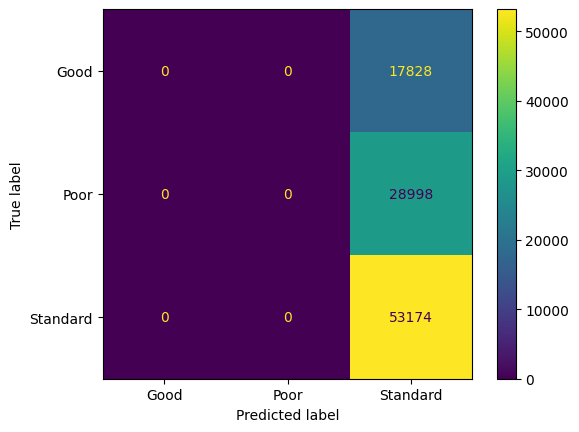

In [92]:
print(classification_report(list(df['Credit_Score']), ['Standard'] * df.shape[0]))
acc = accuracy_score(list(df['Credit_Score']), ['Standard'] * df.shape[0])
acc = accuracy_score(list(df['Credit_Score']), ['Standard'] * df.shape[0])
print("Train accuracy:", acc)
ConfusionMatrixDisplay.from_predictions(list(df['Credit_Score']), ['Standard'] * df.shape[0])
plt.show()

При условии того, что точность равна 0.53, что, казалось бы, не так плохо, значение presicion крайне низкое, как и значение F1.

Визуализируем данные, затем посмотрим на зависимости признаков, дополнительно обработаем данные и обучим модели.

#### 4-5. Улучшение бейзлайна

#### Визуализация

In [93]:
df2 = df.copy()

In [94]:
# import seaborn as sns
# import plotly.figure_factory as ff
# import plotly.express as px
# import matplotlib.pyplot as plt
# from matplotlib import colors
# import matplotlib.ticker as mtick
# import plotly.graph_objects as go
# import random
# import math

Посмотрим

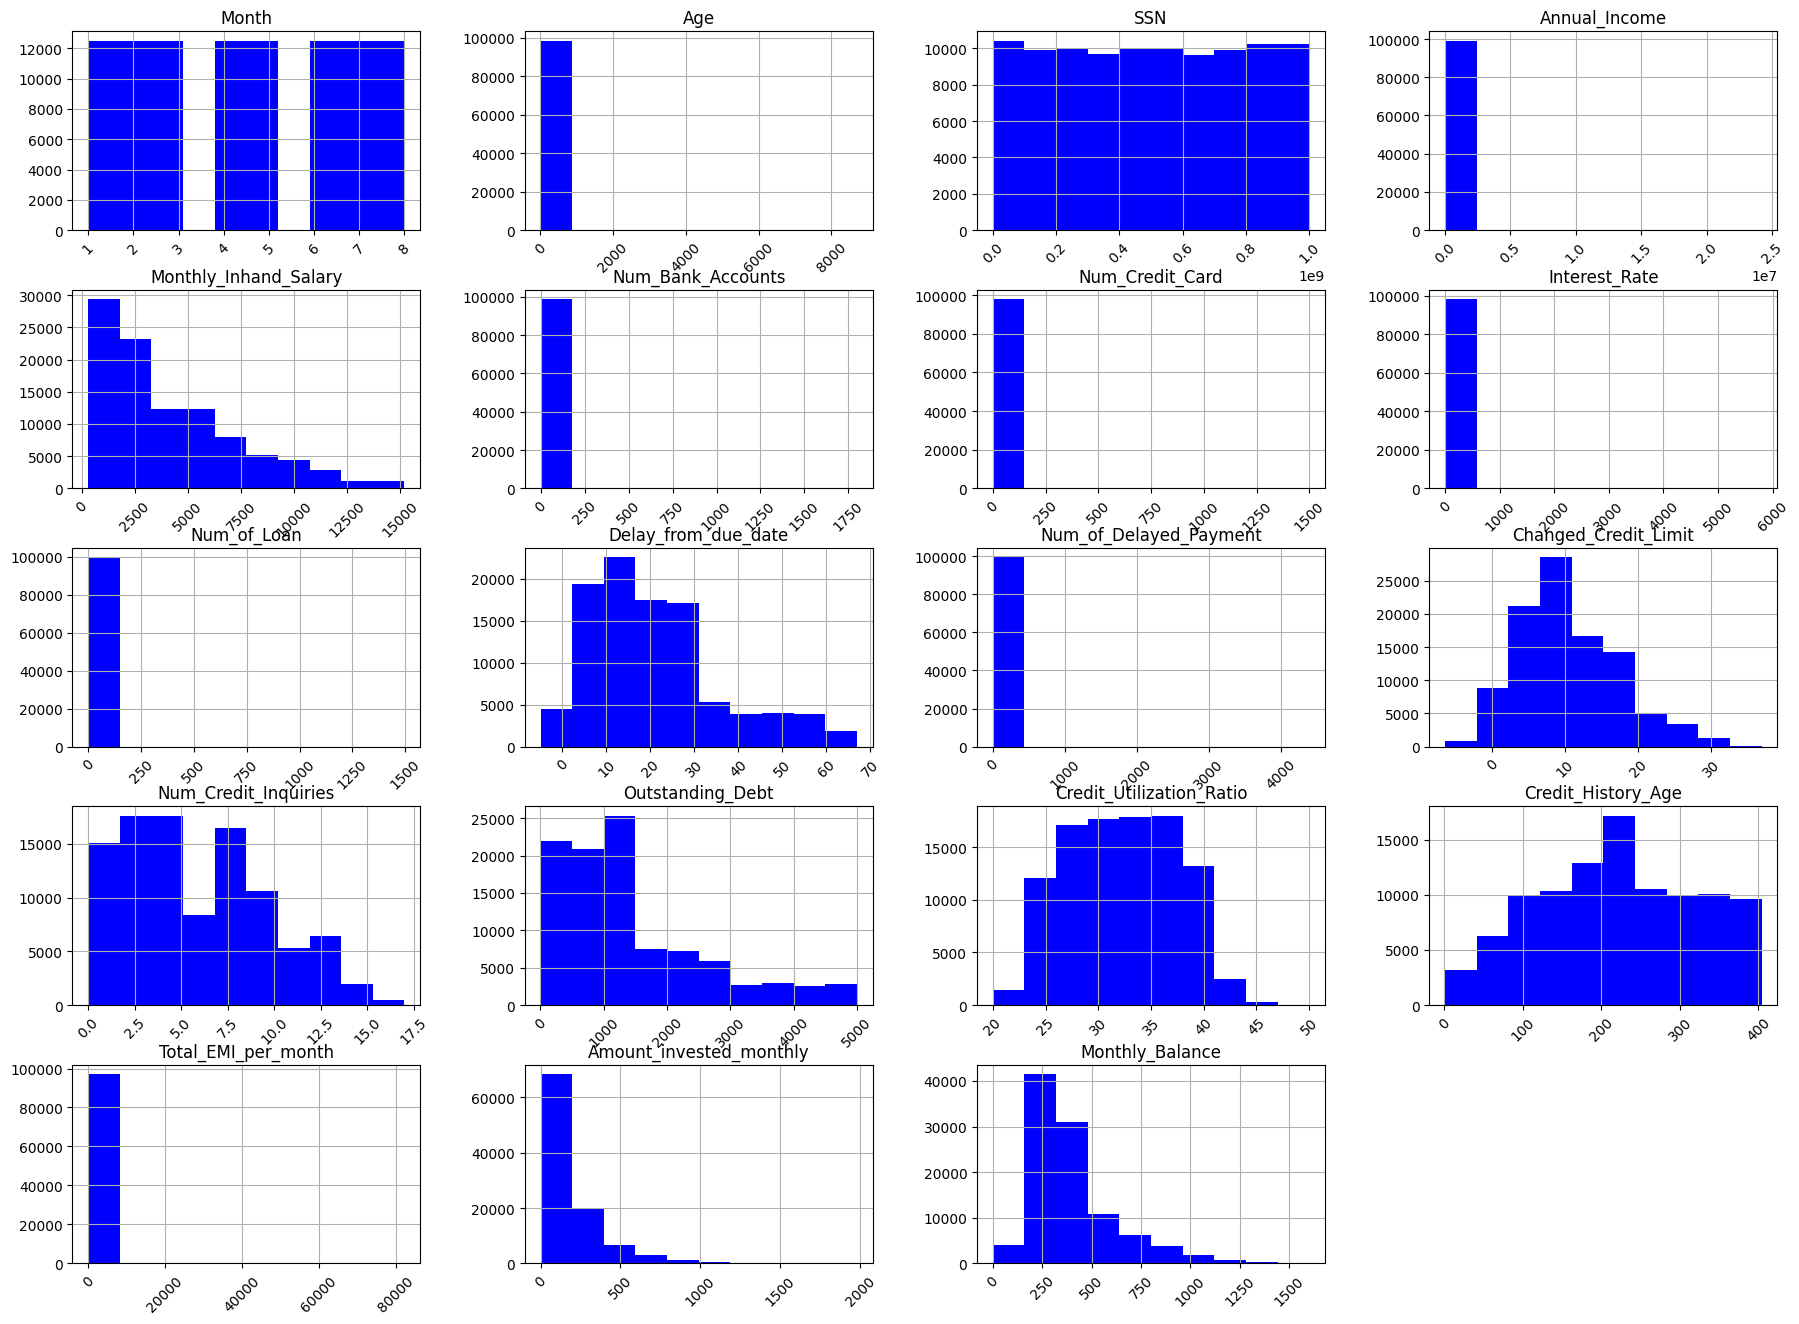

In [95]:
df2.hist(figsize=(22, 16), xrot=45, color='b')
plt.show()

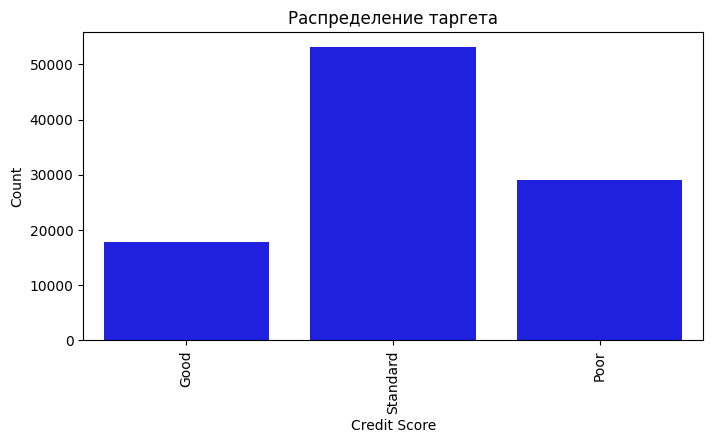

In [96]:
plt.figure(figsize=(8, 4))
sns.countplot(data=df2, x='Credit_Score', color='b')
plt.xlabel('Credit Score')
plt.ylabel('Count')
plt.title('Распределение таргета')
plt.xticks(rotation=90)
plt.show()

Попробуем выдвинуть некоторые гипотезы:

* Возраст влияет на кредитный рейтинг
* Профессия влияет на рейтинг, при этом наибольшее число людей с низким рейтингом будет не на интеллектуальном типе работ
* Годичный заработок влияет на рейтинг

##### Возраст

In [97]:
df2['Age'].unique()

array([  23,  500,   28, ..., 4808, 2263, 1342])

<Axes: xlabel='Age', ylabel='Density'>

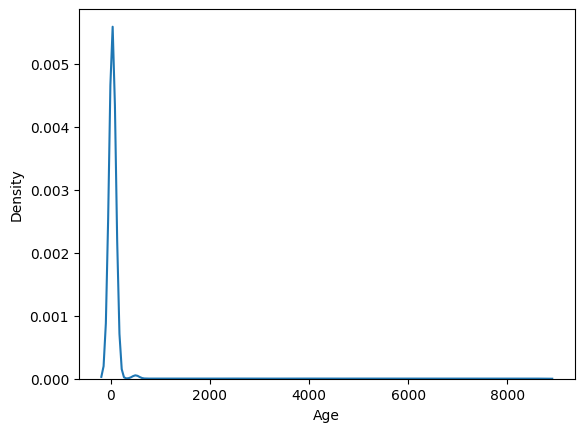

In [98]:
sns.kdeplot(df2['Age'])

In [99]:
age_bins = [14, 24, 34, 44, 54, 64, 74]
age_labels = ['14-24', '25-34', '35-44', '45-54', '55-64', '65-74']
df2['Grouped_Age'] = pd.cut(df2['Age'], bins=age_bins, labels=age_labels, right=False)
print(df2[['Age', 'Grouped_Age']].head())

   Age Grouped_Age
0   23       14-24
1   23       14-24
2  500         NaN
3   23       14-24
4   23       14-24


<Axes: xlabel='Grouped_Age', ylabel='count'>

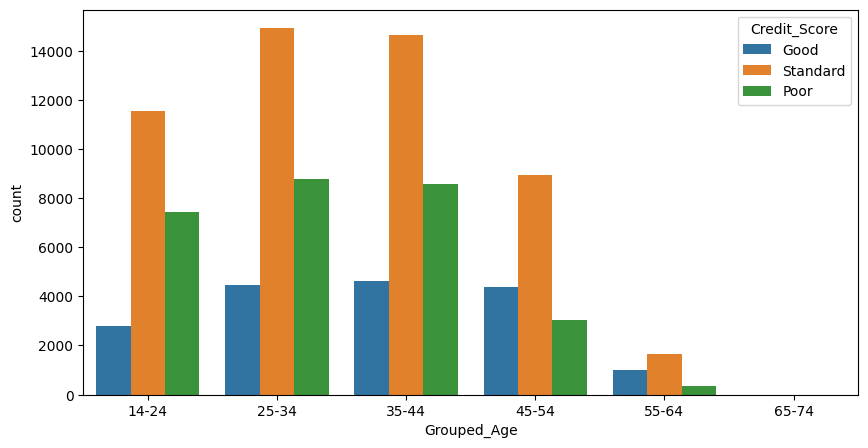

In [100]:
plt.figure(figsize=(10,5))
sns.countplot(data=df2, x='Grouped_Age', hue='Credit_Score')

Точно ответить нельзя, но можно заметить, что возрастные группы старше 45 лет имеют наименьшую долю людей, имеющих рейтинг Poor

##### Профессия

In [101]:
df['Occupation'].unique()

array(['Scientist', 'Teacher', 'Engineer', 'Entrepreneur', 'Developer',
       'Lawyer', 'Media_Manager', 'Doctor', 'Journalist', 'Manager',
       'Accountant', 'Musician', 'Mechanic', 'Writer', 'Architect'],
      dtype=object)

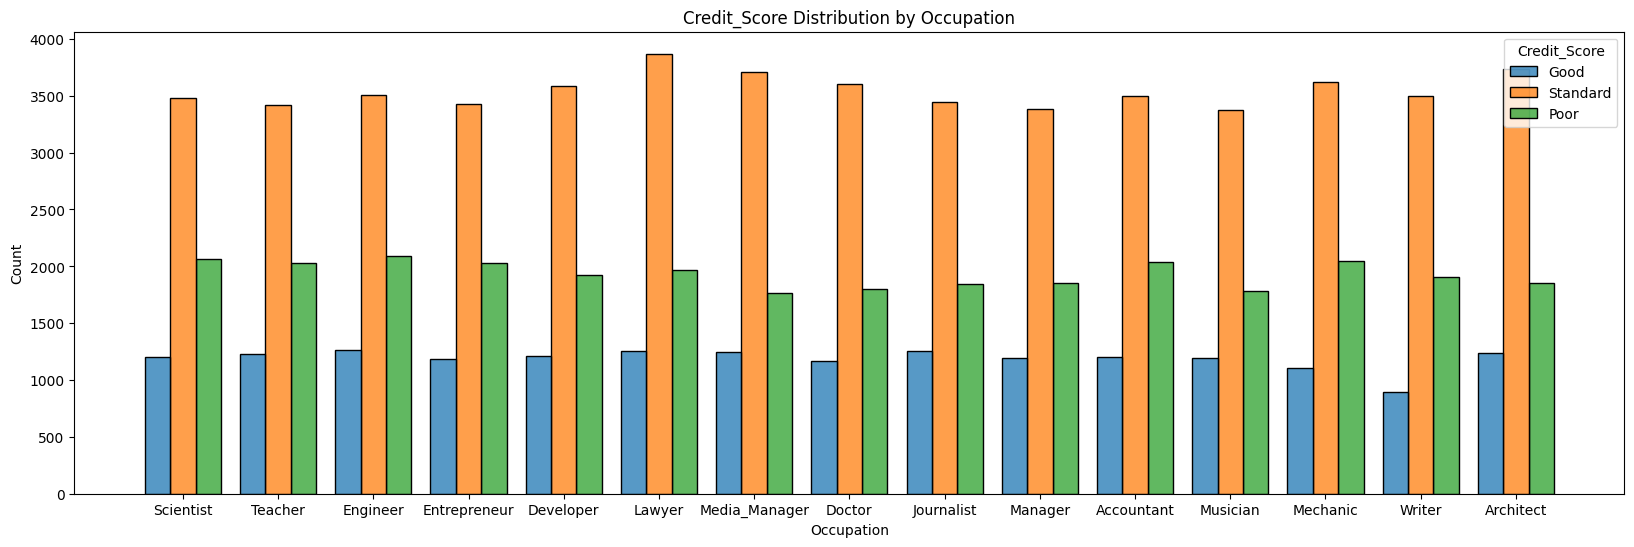

In [102]:
plt.figure(figsize=(20, 6))
sns.histplot(data=df, x="Occupation", hue="Credit_Score", multiple="dodge", shrink=.8)
plt.title("Credit_Score Distribution by Occupation")
plt.xlabel("Occupation")
plt.ylabel("Count")
plt.show()

Судя по графикам, наибольшее число людей с рейтингом Poor - инженеры. Далее идут архитекторы, юристы и медиа-менеджеры.

##### Заработок за год

In [103]:
credit_good = df2[df2.Credit_Score == 'Good']
credit_good.Annual_Income.describe()

,Annual_Income
count,1.782800e+04
mean,1.849366e+05
std,1.409983e+06
min,7.189540e+03
25%,2.989237e+04
50%,4.553643e+04
75%,9.896787e+04
max,2.419806e+07


In [104]:
credit_std = df2[df2.Credit_Score == 'Standard']
credit_std.Annual_Income.describe()

,Annual_Income
count,5.317400e+04
mean,1.852492e+05
std,1.468144e+06
min,7.006035e+03
25%,2.007847e+04
50%,3.720106e+04
75%,7.391061e+04
max,2.418881e+07


In [105]:
credit_poor = df2[df2.Credit_Score == 'Poor']
credit_poor.Annual_Income.describe()

,Annual_Income
count,2.899800e+04
mean,1.549790e+05
std,1.368526e+06
min,7.005930e+03
25%,1.685729e+04
50%,3.227642e+04
75%,5.836736e+04
max,2.391294e+07


Можно сказать, что средний заработок людей с рейтингом Poor меньше, чем у людей с другими рейтингами. Также можно заметить, что средний заработок остальных категорий примерно одинаковый.

##### Посмотрим на корреляцию признаков

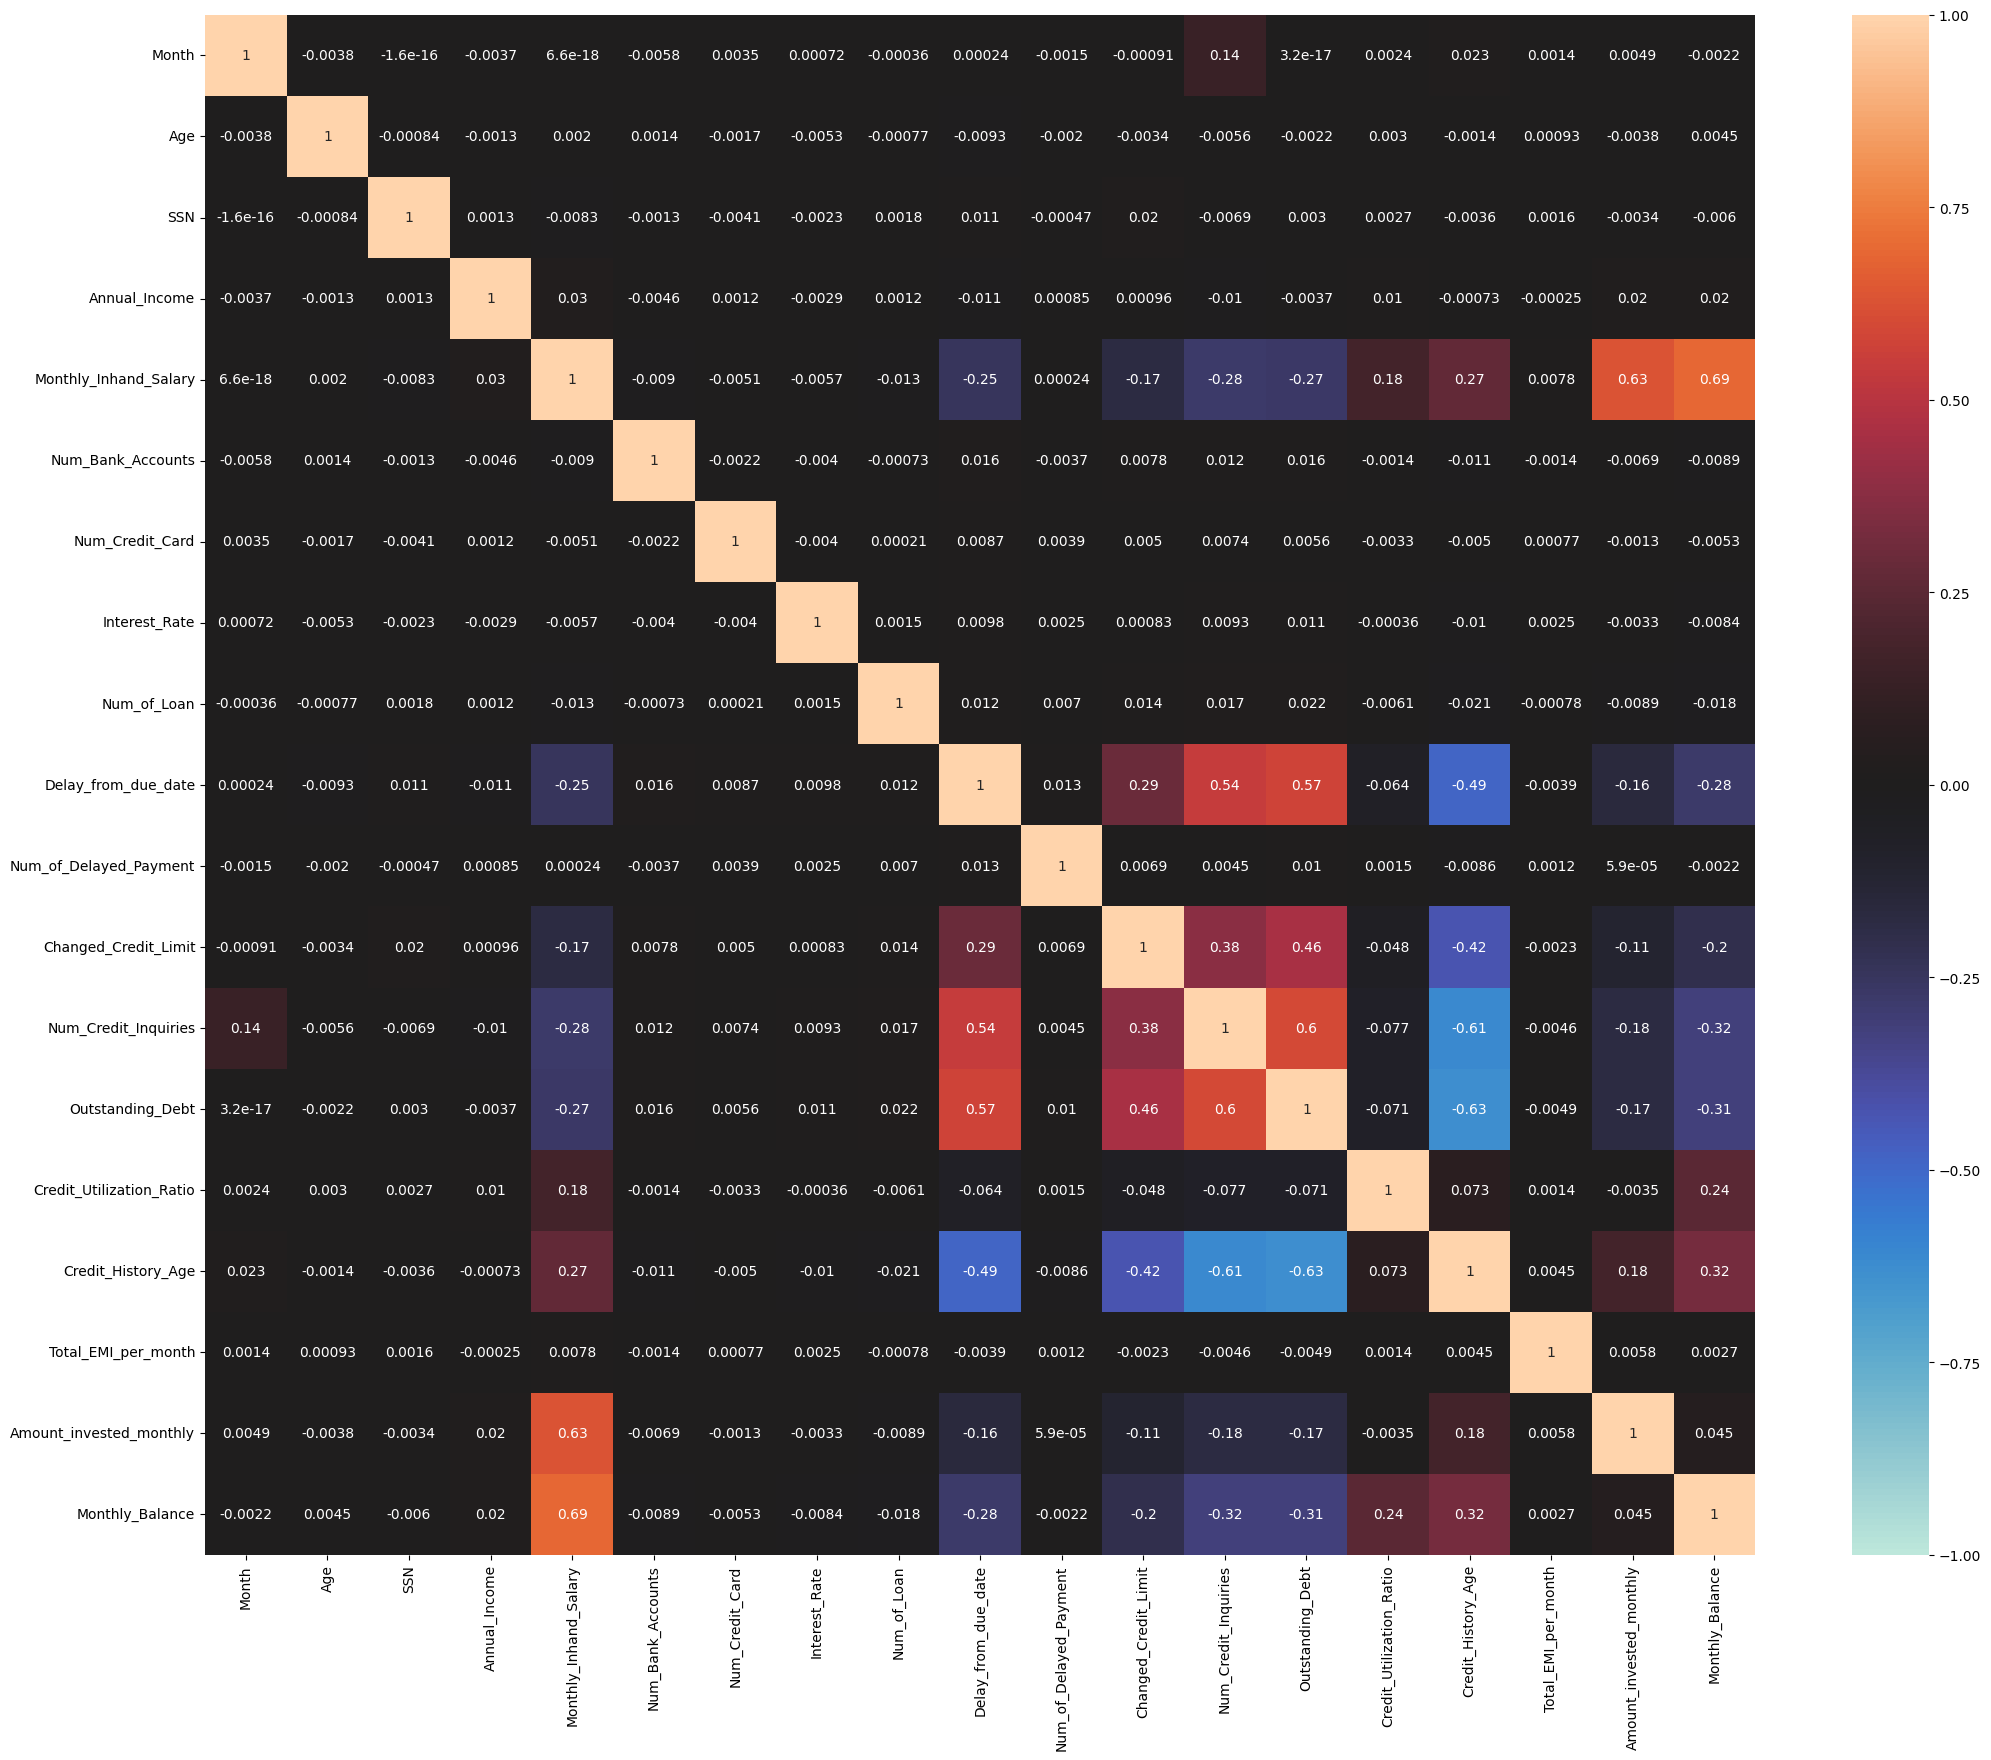

In [106]:
selected_columns = df.select_dtypes(include=['number'])
plt.figure(figsize=(25, 20))
sns.heatmap(selected_columns.corr(), annot=True, vmin=-1, vmax=1, center=0)
plt.show()

Многие признаки сильно коррелируют друг с другом, поработаем с этим чуть позже

#### Предобработка данных

Воспользуемся LabelEncoding для кодирования кредитного рейтинга

In [107]:
columns=['Credit_Score']
for item in columns:
    df[item] = LabelEncoder().fit_transform(df[item])
df.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,1,Aaron Maashoh,23,821000265,Scientist,19114.12,1824.843333,3,...,Good,809.98,26.822620,265.0,No,49.574949,80.415295,High_spent_Small_value_payments,312.494089,0
1,0x1603,CUS_0xd40,2,Aaron Maashoh,23,821000265,Scientist,19114.12,1824.843333,3,...,Good,809.98,31.944960,266.0,No,49.574949,118.280222,Low_spent_Large_value_payments,284.629162,0
2,0x1604,CUS_0xd40,3,Aaron Maashoh,500,821000265,Scientist,19114.12,1824.843333,3,...,Good,809.98,28.609352,267.0,No,49.574949,81.699521,Low_spent_Medium_value_payments,331.209863,0
3,0x1605,CUS_0xd40,4,Aaron Maashoh,23,821000265,Scientist,19114.12,1824.843333,3,...,Good,809.98,31.377862,268.0,No,49.574949,199.458074,Low_spent_Small_value_payments,223.451310,0
4,0x1606,CUS_0xd40,5,Aaron Maashoh,23,821000265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,269.0,No,49.574949,41.420153,High_spent_Medium_value_payments,341.489231,0


In [108]:
df['Credit_Score'].value_counts()

,count
Credit_Score,
2,53174
1,28998
0,17828


In [111]:
columns = ['Payment_of_Min_Amount', 'Payment_Behaviour', 'Name', 'Occupation', 'Credit_Mix']
for item in columns:
    df[item] = ce.LeaveOneOutEncoder().fit_transform(df[item],df['Credit_Score'])

In [112]:
df.ID = df.ID.apply(lambda x: int(x,16)).astype(np.int64)
df.Customer_ID = df.Customer_ID.apply(lambda x: int(x[4:],16)).astype(np.int64)

In [113]:
df.drop('Type_of_Loan', axis=1, inplace=True)

In [114]:
df.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,5634,3392,1,0.285714,23,821000265,1.338277,19114.12,1824.843333,3,...,0.863016,809.98,26.822620,265.0,1.099647,49.574949,80.415295,1.355789,312.494089,0
1,5635,3392,2,0.285714,23,821000265,1.338277,19114.12,1824.843333,3,...,0.863016,809.98,31.944960,266.0,1.099647,49.574949,118.280222,1.359256,284.629162,0
2,5636,3392,3,0.285714,500,821000265,1.338277,19114.12,1824.843333,3,...,0.863016,809.98,28.609352,267.0,1.099647,49.574949,81.699521,1.337825,331.209863,0
3,5637,3392,4,0.285714,23,821000265,1.338277,19114.12,1824.843333,3,...,0.863016,809.98,31.377862,268.0,1.099647,49.574949,199.458074,1.385327,223.451310,0
4,5638,3392,5,0.285714,23,821000265,1.338277,19114.12,1824.843333,3,...,0.863016,809.98,24.797347,269.0,1.099647,49.574949,41.420153,1.343971,341.489231,0


In [115]:
df.dtypes

,0
ID,int64
Customer_ID,int64
Month,int64
Name,float64
Age,int64
SSN,int64
Occupation,float64
Annual_Income,float64
Monthly_Inhand_Salary,float64
Num_Bank_Accounts,int64


In [116]:
columns2 =['Annual_Income','Age','Num_Credit_Card','Interest_Rate','Delay_from_due_date','Num_of_Delayed_Payment','Monthly_Balance',
                           'Num_Credit_Inquiries','Changed_Credit_Limit','Credit_History_Age',
                           'Outstanding_Debt','Total_EMI_per_month']
for item in columns2:
    mean_encoding = df.groupby([item])['Credit_Score'].mean()
    df[item] = df[item].map(mean_encoding)
df.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,5634,3392,1,0.285714,1.380181,821000265,1.338277,0.25,1824.843333,3,...,0.863016,0.25,26.822620,1.289593,1.099647,0.25,80.415295,1.355789,0.0,0
1,5635,3392,2,0.285714,1.380181,821000265,1.338277,0.25,1824.843333,3,...,0.863016,0.25,31.944960,1.279070,1.099647,0.25,118.280222,1.359256,0.0,0
2,5636,3392,3,0.285714,1.319413,821000265,1.338277,0.25,1824.843333,3,...,0.863016,0.25,28.609352,1.206767,1.099647,0.25,81.699521,1.337825,0.0,0
3,5637,3392,4,0.285714,1.380181,821000265,1.338277,0.25,1824.843333,3,...,0.863016,0.25,31.377862,1.252830,1.099647,0.25,199.458074,1.385327,0.0,0
4,5638,3392,5,0.285714,1.380181,821000265,1.338277,0.25,1824.843333,3,...,0.863016,0.25,24.797347,1.208791,1.099647,0.25,41.420153,1.343971,0.0,0


Перейдём к выявлению важных признаков, а также нормализации.

In [117]:
X = df.drop('Credit_Score', axis=1)
y = df['Credit_Score']

Воспользуемся VIF

In [118]:
vif_data = pd.DataFrame()
vif_data["target"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

In [119]:
vif_data

,target,VIF
0,ID,1.000080
1,Customer_ID,1.001889
2,Month,1.016334
3,Name,4.780346
4,Age,1.053429
5,SSN,3.965591
6,Occupation,0.581561
7,Annual_Income,31.955799
8,Monthly_Inhand_Salary,2.126201
9,Num_Bank_Accounts,1.000451


Признаки Name, Annual_Income, Number_of_Loans, Total_EMI_per_month, and Outstanding_Debt могут быть предсказаны с помощью других признаков, поэтому уберём их.

In [120]:
df3 = df.copy()

In [121]:
columns3 = ['Name', 'Annual_Income', 'Num_of_Loan', 'Outstanding_Debt', 'Total_EMI_per_month']
for item in columns3:
    df3.drop(item, axis=1, inplace=True)
X = df3.drop('Credit_Score', axis=1)
y = df3['Credit_Score']

In [122]:
X.columns

Index(['ID', 'Customer_ID', 'Month', 'Age', 'SSN', 'Occupation',
       'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card',
       'Interest_Rate', 'Delay_from_due_date', 'Num_of_Delayed_Payment',
       'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Credit_Mix',
       'Credit_Utilization_Ratio', 'Credit_History_Age',
       'Payment_of_Min_Amount', 'Amount_invested_monthly', 'Payment_Behaviour',
       'Monthly_Balance'],
      dtype='object')

Так как наблюдается дисбаланс в классах, воспользуемся SMOTE (Synthetic Minority Over-sampling Technique), чтобы обеспечить примерное равенство в количестве примеров для каждого класса

In [123]:
smote = SMOTE()
X, y = smote.fit_resample(X, y)

Разобъём на тренировочную и тестовые выборки

In [124]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

В этот раз попробуем использовать MinMaxScaler для нормализации

In [125]:
from sklearn.preprocessing import MinMaxScaler

In [126]:
scaler = StandardScaler()
features = X_train.columns
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train,columns=features)
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test,columns=features)
X_train.head()

,ID,Customer_ID,Month,Age,SSN,Occupation,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,...,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance
0,1.396602,-0.559416,-1.098215,0.495626,-0.191577,-0.712932,0.217632,-0.118716,0.184531,-0.083435,...,0.088977,-0.100844,-1.062385,-1.159557,0.349038,-1.222121,-1.133204,-0.429914,-0.405246,-1.243966
1,0.414563,1.189911,-0.163418,0.066644,-0.165243,2.788599,0.555853,-0.071048,0.184531,-0.142006,...,0.099059,-2.478665,-1.062385,-1.159557,0.374448,-0.999805,-1.133204,-0.414212,-1.615678,-1.243966
2,-1.330219,1.108842,-0.163418,0.066644,-0.267309,-0.695324,-0.398012,-0.109182,-3.394308,-0.239820,...,0.098964,-2.478994,-1.062385,-1.159557,1.186860,-0.193795,-1.133204,0.135872,1.451246,-1.243966
3,-0.093902,-0.613040,-0.163418,0.066644,-0.661042,0.701993,-0.711679,-0.147317,0.221346,-2.132230,...,-0.739697,-1.124823,-1.310801,-1.159557,0.913476,-0.537259,-0.733120,-0.130809,0.587286,-1.243966
4,0.523374,1.703984,1.706177,-1.122568,-0.504617,0.643567,-0.445968,-0.099649,0.240428,1.994448,...,0.795421,0.628331,-1.310801,1.115706,-1.780455,0.111296,-1.133485,-0.735029,0.122754,1.226176


In [127]:
model_names = []
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

In [144]:
def Evaluate(model):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test,y_pred))
    acc = accuracy_score(y_test,y_pred)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)
    print("Train accuracy:", train_acc)
    print("Test accuracy:", test_acc)
    precision = precision_score(y_test, y_pred, average='micro')
    recall = recall_score(y_test, y_pred, average='micro')
    f1 = f1_score(y_test, y_pred, average='micro')
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    model_names.append(model)
    accuracy_scores.append(acc)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    plt.show()

In [145]:
def EvaluateS(model, v=100):
    model.fit(X_train[:v],y_train[:v])
    y_pred = model.predict(X_test[:v])
    print(classification_report(y_test[:v],y_pred[:v]))
    acc = accuracy_score(y_test[:v],y_pred[:v])
    y_pred_train = model.predict(X_train[:v])
    y_pred_test = model.predict(X_test[:v])
    train_acc = accuracy_score(y_train[:v], y_pred_train)
    test_acc = accuracy_score(y_test[:v], y_pred_test)
    print("Train accuracy:", train_acc)
    print("Test accuracy:", test_acc)
    precision = precision_score(y_test[:v], y_pred[:v], average='micro')
    recall = recall_score(y_test[:v], y_pred[:v], average='micro')
    f1 = f1_score(y_test[:v], y_pred[:v], average='micro')
    ConfusionMatrixDisplay.from_predictions(y_test[:v], y_pred[:v])
    model_names.append(model)
    accuracy_scores.append(acc)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    plt.show()

Обучим несколько моделей

##### a. KNN

In [131]:

from sklearn.neighbors import KNeighborsClassifier

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     10726
           1       0.94      0.97      0.96     10544
           2       0.99      0.94      0.96     10635

    accuracy                           0.97     31905
   macro avg       0.97      0.97      0.97     31905
weighted avg       0.97      0.97      0.97     31905

Train accuracy: 0.9820243384502064
Test accuracy: 0.9681241184767277


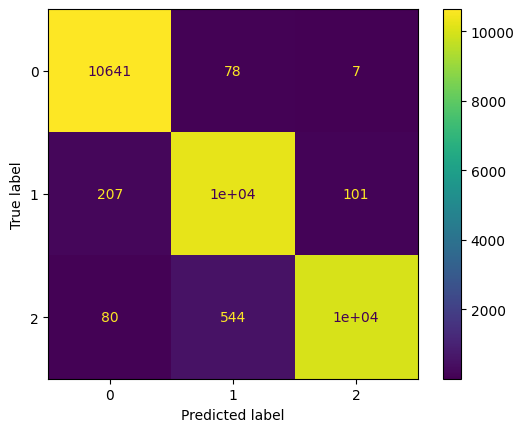

In [132]:
Evaluate(KNeighborsClassifier())

**##### b. Logistic Regression Model**

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     10619
           1       0.98      0.99      0.99     10671
           2       0.99      0.99      0.99     10615

    accuracy                           0.99     31905
   macro avg       0.99      0.99      0.99     31905
weighted avg       0.99      0.99      0.99     31905

Train accuracy: 0.9893274407014739
Test accuracy: 0.9897508227550541


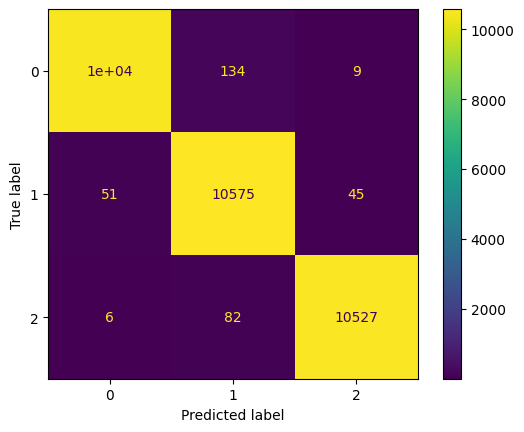

In [ ]:
Evaluate(LogisticRegression())

##### c. Ridge Classifier

              precision    recall  f1-score   support

           0       0.87      0.96      0.91     10726
           1       0.94      0.82      0.88     10544
           2       0.95      0.98      0.97     10635

    accuracy                           0.92     31905
   macro avg       0.92      0.92      0.92     31905
weighted avg       0.92      0.92      0.92     31905

Train accuracy: 0.9153169248611078
Test accuracy: 0.9189468735307945


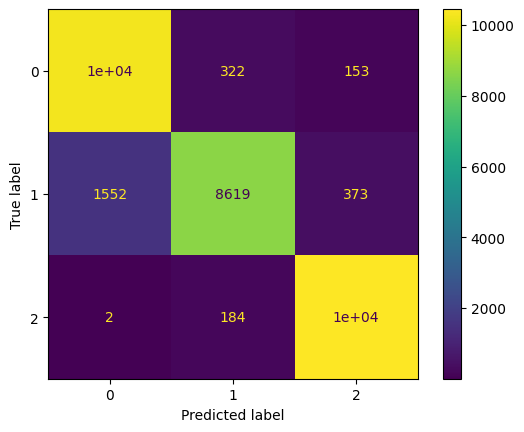

In [134]:
Evaluate(RidgeClassifier())

##### Own realisation of LR

In [136]:
class OwnLogisticRegression:
    def __init__(self, num_classes, learning_rate=0.01, iterations=1000):
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.num_classes = num_classes

    def fit(self, X, Y):
        self.m, self.n = X.shape
        self.W = np.zeros((self.n, self.num_classes))
        self.b = np.zeros((1, self.num_classes))
        self.X = np.array(X)
        self.Y = np.array(Y)
        tmp = np.zeros((self.m, self.num_classes))
        tmp[np.arange(self.m), Y] = 1
        self.Y = tmp
        for i in range(self.iterations):
            A = self.softmax(self.X.dot(self.W) + self.b)
            dZ = A - self.Y
            dW = (self.X.T).dot(dZ) / self.m
            db = np.sum(dZ, axis=0, keepdims=True) / self.m
            self.W -= self.learning_rate * dW
            self.b -= self.learning_rate * db
        return self

    def predict(self, X):
        X = np.array(X)
        Z = self.softmax(X.dot(self.W) + self.b)
        Y = np.argmax(Z, axis=1)
        return Y

    def softmax(self, Z):
        exp_Z = np.exp(Z - np.max(Z, axis=1, keepdims=True))
        return exp_Z / np.sum(exp_Z, axis=1, keepdims=True)

              precision    recall  f1-score   support

           0       0.88      0.93      0.91     10726
           1       0.92      0.83      0.87     10544
           2       0.95      0.99      0.97     10635

    accuracy                           0.92     31905
   macro avg       0.92      0.92      0.92     31905
weighted avg       0.92      0.92      0.92     31905

Train accuracy: 0.9150583386225973
Test accuracy: 0.9176618084939665


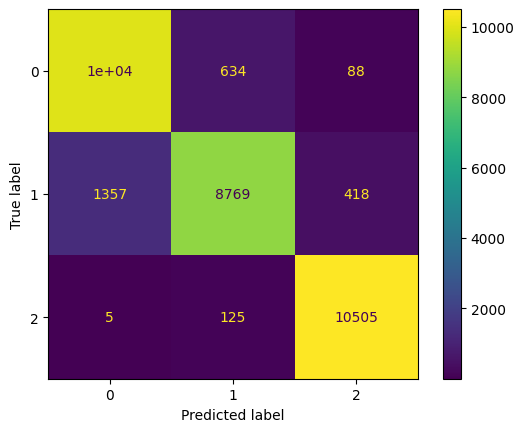

In [137]:
Evaluate(OwnLogisticRegression(3))

Итак, метрики на обычной логистической регрессии очень хорошие

##### d. Decision Tree

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10619
           1       1.00      1.00      1.00     10671
           2       1.00      1.00      1.00     10615

    accuracy                           1.00     31905
   macro avg       1.00      1.00      1.00     31905
weighted avg       1.00      1.00      1.00     31905

Train accuracy: 1.0
Test accuracy: 0.9996552264535339


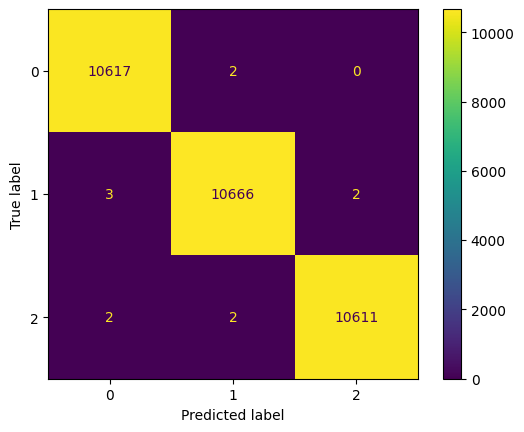

In [ ]:
Evaluate(DecisionTreeClassifier())

##### e. Random Forest

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10619
           1       1.00      1.00      1.00     10671
           2       1.00      1.00      1.00     10615

    accuracy                           1.00     31905
   macro avg       1.00      1.00      1.00     31905
weighted avg       1.00      1.00      1.00     31905

Train accuracy: 1.0
Test accuracy: 0.9998432847516063


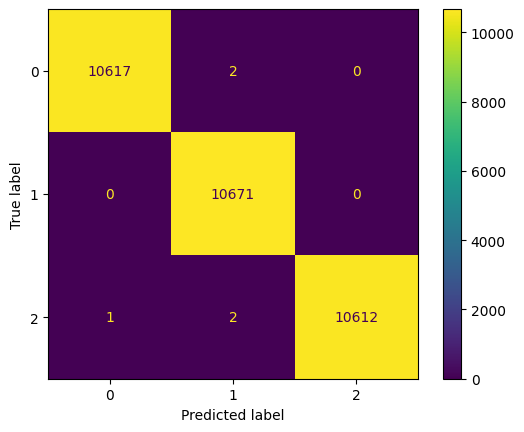

In [ ]:
Evaluate(RandomForestClassifier())

##### f. Gradient Boosting

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10619
           1       1.00      1.00      1.00     10671
           2       1.00      1.00      1.00     10615

    accuracy                           1.00     31905
   macro avg       1.00      1.00      1.00     31905
weighted avg       1.00      1.00      1.00     31905

Train accuracy: 0.9999451483736492
Test accuracy: 0.9997492556025701


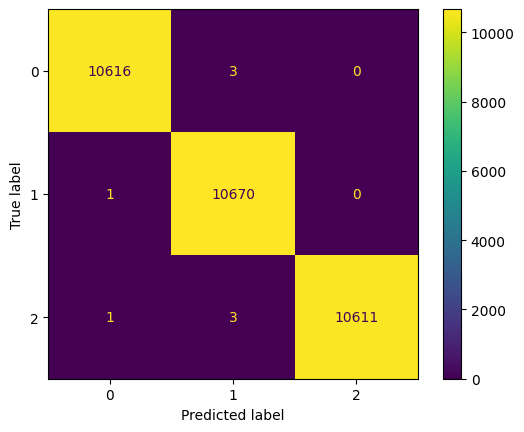

In [ ]:
Evaluate(GradientBoostingClassifier())

##### Own KNN

In [138]:
class OwnKNNClassifier:
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors

    def fit(self, X, y):
        self.X_train = np.array(X)
        self.y_train = np.array(y).flatten()

    def predict(self, X):
        predictions = []
        X = np.array(X)
        for x in X:
            distances = np.sqrt(((self.X_train - x) ** 2).sum(axis=1))
            neighbors_idx = distances.argsort()[:self.n_neighbors]
            neighbors_classes = self.y_train[neighbors_idx]
            majority_class = np.bincount(neighbors_classes).argmax()
            predictions.append(majority_class)
        return np.array(predictions)

              precision    recall  f1-score   support

           0       0.83      0.92      0.87       170
           1       0.62      0.82      0.71       161
           2       0.93      0.54      0.69       169

    accuracy                           0.76       500
   macro avg       0.79      0.76      0.76       500
weighted avg       0.80      0.76      0.76       500

Train accuracy: 0.864
Test accuracy: 0.762


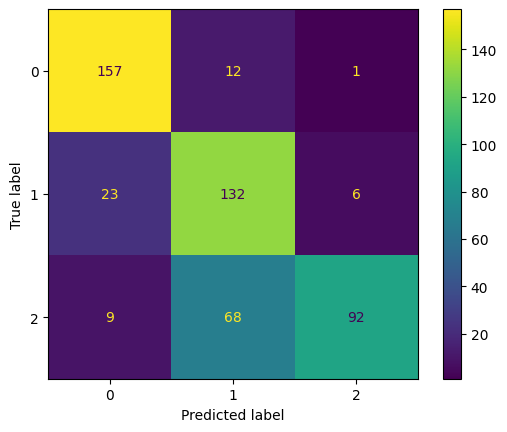

In [150]:
EvaluateS(OwnKNNClassifier(), 500)

##### Own Decision Tree

In [ ]:
class OwnDecisionTreeClassifier:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth

    def fit(self, X, y):
        self.classes = np.unique(y)
        self.tree = {}

        for class_label in self.classes:
            binary_y = (y == class_label).astype(int)
            subtree = self._build_tree(X, binary_y, depth=0)
            self.tree[class_label] = subtree

    def _build_tree(self, X, y, depth):
        num_samples, num_features = X.shape
        if len(np.unique(y)) == 1 or (self.max_depth is not None and depth == self.max_depth):
            return {'class': self._most_common_class(y)}
        best_feature, best_threshold = self._find_best_split(X, y)
        if best_feature is None:
            return {'class': self._most_common_class(y)}
        left_mask = X[:, best_feature] <= best_threshold
        right_mask = ~left_mask
        left_subtree = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        right_subtree = self._build_tree(X[right_mask], y[right_mask], depth + 1)
        return {'feature_index': best_feature,
                'threshold': best_threshold,
                'left': left_subtree,
                'right': right_subtree}

    def _find_best_split(self, X, y):
        num_samples, num_features = X.shape
        if num_samples <= 1:
            return None, None
        current_gini = self._gini(y)
        best_gini = 1.0
        best_feature = None
        best_threshold = None
        for feature_index in range(num_features):
            unique_values = np.unique(X[:, feature_index])
            thresholds = (unique_values[:-1] + unique_values[1:]) / 2.0
            for threshold in thresholds:
                left_mask = X[:, feature_index] <= threshold
                right_mask = ~left_mask
                if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
                    continue
                left_gini = self._gini(y[left_mask])
                right_gini = self._gini(y[right_mask])
                weighted_gini = (np.sum(left_mask) * left_gini + np.sum(right_mask) * right_gini) / num_samples
                if weighted_gini < best_gini:
                    best_gini = weighted_gini
                    best_feature = feature_index
                    best_threshold = threshold
        return best_feature, best_threshold

    def _gini(self, y):
        classes, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        gini = 1.0 - np.sum(probabilities**2)
        return gini

    def _most_common_class(self, y):
        classes, counts = np.unique(y, return_counts=True)
        most_common_class = classes[np.argmax(counts)]
        return most_common_class

    def predict(self, X):
        return np.array([self._predict_tree(sample, self.tree) for sample in X])

    def _predict_tree(self, x, node):
        if 'class' in node:
            return node['class']
        else:
            if x[node['feature_index']] <= node['threshold']:
                return self._predict_tree(x, node['left'])
            else:
                return self._predict_tree(x, node['right'])

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        87
           1       0.59      0.58      0.58        88
           2       0.51      0.52      0.52        75

    accuracy                           0.71       250
   macro avg       0.70      0.70      0.70       250
weighted avg       0.71      0.71      0.71       250

Train accuracy: 1.0
Test accuracy: 0.708


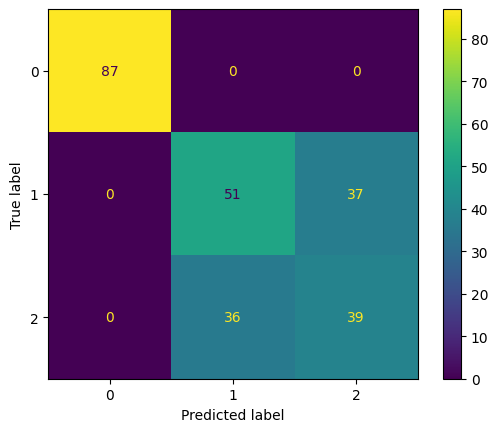

In [ ]:
EvaluateS(OwnDecisionTreeClassifier(), 250)

##### Own Random Forest

In [ ]:
class OwnRandomForestClassifier:
    def __init__(self, n_trees=10, max_depth=5, random_state=None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.random_state = random_state
        self.trees = []

    def fit(self, X, y):
        np.random.seed(self.random_state)
        for _ in range(self.n_trees):
            indices = np.random.choice(len(X), len(X), replace=True)
            X_subset, y_subset = X[indices], y[indices]
            tree = OwnDecisionTreeClassifier(max_depth=self.max_depth)
            tree.fit(X_subset, y_subset)
            self.trees.append(tree)

    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.trees])
        majority_votes = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions)
        return majority_votes

              precision    recall  f1-score   support

           0       1.00      0.99      0.99        87
           1       0.98      0.95      0.97        88
           2       0.94      0.97      0.95        75

    accuracy                           0.97       250
   macro avg       0.97      0.97      0.97       250
weighted avg       0.97      0.97      0.97       250

Train accuracy: 1.0
Test accuracy: 0.972


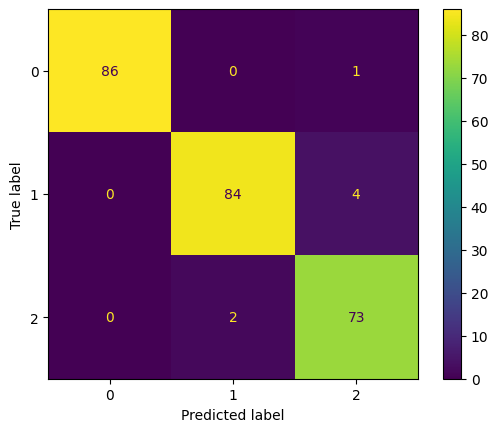

In [ ]:
EvaluateS(OwnRandomForestClassifier(), 250)

##### Own Gradient Boosting

In [ ]:
class OwnGradientBoostingClassifier:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=5):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.models = []

    def fit(self, X, y):
        predictions = np.full_like(y, np.mean(y), dtype=np.float64)
        for _ in range(self.n_estimators):
            residuals = y - predictions
            tree = OwnDecisionTreeClassifier(max_depth=self.max_depth)
            tree.fit(X, residuals)
            tree_predictions = tree.predict(X)
            predictions += self.learning_rate * tree_predictions
            self.models.append(tree)

    def predict(self, X):
        predictions = np.full(X.shape[0], np.mean([tree.predict(X) for tree in self.models]), dtype=np.float64)
        for tree in self.models:
            tree_predictions = tree.predict(X)
            predictions += self.learning_rate * tree_predictions
        return np.round(predictions).astype(int)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99        87
           1       0.99      1.00      0.99        88
           2       1.00      1.00      1.00        75

    accuracy                           1.00       250
   macro avg       1.00      1.00      1.00       250
weighted avg       1.00      1.00      1.00       250

Train accuracy: 1.0
Test accuracy: 0.996


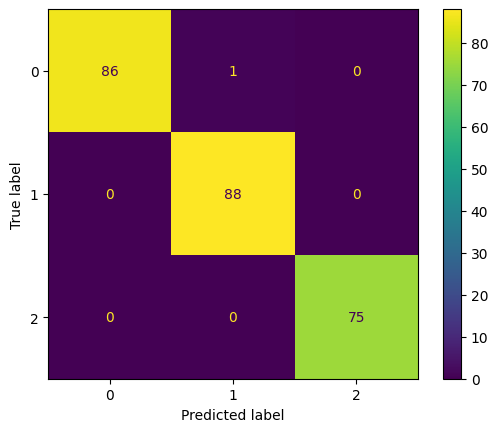

In [ ]:
EvaluateS(OwnGradientBoostingClassifier(), 250)

Learning rate set to 0.101327
0:	learn: 0.9112261	total: 97ms	remaining: 1m 36s
1:	learn: 0.7717684	total: 141ms	remaining: 1m 10s
2:	learn: 0.6629010	total: 188ms	remaining: 1m 2s
3:	learn: 0.5748471	total: 239ms	remaining: 59.6s
4:	learn: 0.5022361	total: 279ms	remaining: 55.5s
5:	learn: 0.4419254	total: 327ms	remaining: 54.2s
6:	learn: 0.3899454	total: 375ms	remaining: 53.2s
7:	learn: 0.3456158	total: 415ms	remaining: 51.5s
8:	learn: 0.3071307	total: 465ms	remaining: 51.2s
9:	learn: 0.2738564	total: 504ms	remaining: 49.9s
10:	learn: 0.2452129	total: 551ms	remaining: 49.6s
11:	learn: 0.2191622	total: 590ms	remaining: 48.6s
12:	learn: 0.1962265	total: 636ms	remaining: 48.3s
13:	learn: 0.1760082	total: 676ms	remaining: 47.6s
14:	learn: 0.1585434	total: 722ms	remaining: 47.4s
15:	learn: 0.1426431	total: 770ms	remaining: 47.3s
16:	learn: 0.1286114	total: 809ms	remaining: 46.8s
17:	learn: 0.1159666	total: 845ms	remaining: 46.1s
18:	learn: 0.1046667	total: 891ms	remaining: 46s
19:	learn: 0

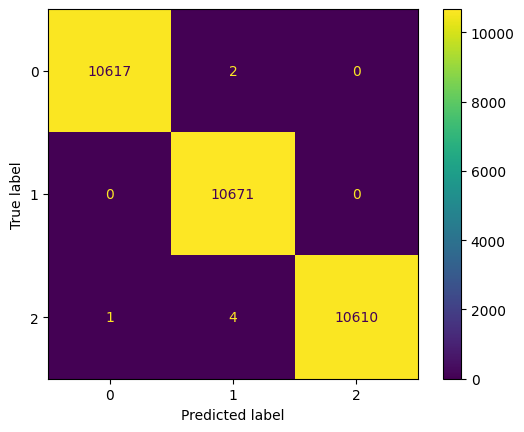

In [ ]:
Evaluate(CatBoostClassifier())

Таким образом, можно отметить, что реализация дерева решений из библиотеки sklearn не подверглась переобучению, тогда как самописная версия демонстрирует признаки переобучения. В остальном результаты оказались вполне ожидаемыми: ансамблевые модели также показали высокую точность предсказаний. Однако использование ансамблевых моделей выглядит избыточным, поскольку даже логистическая регрессия обеспечила достаточно точные результаты.